## Part I: Inferring $\lambda$ From $\rho$

The below algorithm takes in a ribosome size $L$ (typically 10 codons), and a vector of densities $\rho$, and outputs $\alpha$ (translation initiation rate), $\beta$ (translation termination rate), $\lambda$ (smoothed elongation rate) vectors scaled by a constant factor.

For simplicity, the outputs of the algorithm assume that time is scaled in a manner such that the current $J = 1$. However all resulting $\alpha$, $\beta$, $\lambda$ are proportional and scale linearly by some constant $c$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quadprog as qp

In [2]:
def determine_regime(L, rho):
    """Helper function to determine whether L, rho provided constitute LD, HD, or MC regime. Returns 1 for LD, 2 for HD,
    3 for MC, and 0 for error/anomaly in rho vector presented. """
    rho_star = 1 / (L + np.sqrt(L))
    
    # Screening out for anomalies where rho_i < 0 or rho_i > 1/L
    for rho_i in rho:
        if (rho_i < 0 or rho_i > (1 / L)):
            return 0
    
    # LD Testing:
    is_LD = True
    for rho_i in rho:
        if rho_i > rho_star:   # rho_i not within range [0, rho_star]
            is_LD = False
            break
    if is_LD:
        return 1
    
    # HD Testing:
    is_HD = True
    for rho_i in rho:
        if rho_i < rho_star:   # rho_i not within range [rho_star, 1/L]
            is_HD = False
            break
    if is_HD:
        return 2
    
    # MC Testing:
    if (rho[0] < rho_star or rho[len(rho)-1] > rho_star):   # rho_i must start above rho_star, end below rho_star
        return 0   # Anomaly
    has_crossed_rho_star = False   # in MC, only allowed to cross rho_star boundary once
    for rho_i in rho:
        if (not has_crossed_rho_star and rho_i >= rho_star):
            continue   # in MC, we expect that initial values of rho_i > rho_star
        elif (not has_crossed_rho_star and rho_i < rho_star):
            has_crossed_rho_star = True   # we are only allowed to cross rho_star once
        elif (has_crossed_rho_star and rho_i <= rho_star):
            continue   # in MC, we expect that latter values of rho_i < rho_star
        else:
            return 0   # we had a value of rho_i that, after dipping below rho_star resurfaced above rho_star 
    return 3

In [3]:
def invert_densities(L, rho, rho_1_positive, c = 1):
    """Given L, rho vector, and terminal (non-smoothed) rho value, returns alpha, beta, and lambda vector. Also takes in 
    an optional constant time scaling factor c which equals 1 (assumes J = 1) by default."""
    
    rho_0 = rho[0]   # assumes that rho_0 equals to the first density provided in vector
    # rho_1_positive = rho[len(rho) - 1]   # assumes that rho_1_positive equals last density provided in vector
    
    alpha = c / (1 - (L * rho_0))
    beta = c / rho_1_positive
    lambda_vec = np.zeros(len(rho))
    
    for i in range(len(rho)):
        rho_i = rho[i]
        H_i = rho_i * (1 - L*rho_i) / (1 - (L-1)*rho_i)
        lambda_vec[i] = c / H_i
            
    return [alpha, beta, lambda_vec]

Below are the test cases for $\rho_1$ through $\rho_4$:

In [5]:
### Utilities for Making the Plots
sampling_freq = 10   # constant here can be adjusted
x_values = [i*(1/sampling_freq) for i in range(sampling_freq)] + [1]

alpha = 4.0
beta = 1.3333333333333333
regime is 2


(0, 6)

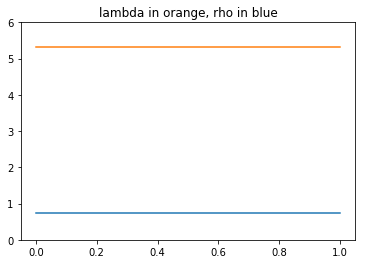

In [7]:
### Test 1:
rho_1 = [0.75 for _ in x_values]
result_1 = invert_densities(1, rho_1, 0.75)   # The 0.75 here acts as rho_1_positive in contrived example.
print("alpha = " + str(result_1[0]))
print("beta = " + str(result_1[1]))
print("regime is " + str(determine_regime(1, rho_1)))
lambda_vec = result_1[2]
plt.plot(x_values, rho_1)
plt.plot(x_values, lambda_vec)
plt.title('lambda in orange, rho in blue')
axes = plt.gca()   # gca = get current axes
axes.set_ylim([0,6])

alpha = 1.3333333333333333
beta = 4.0
regime is 1


(0, 6)

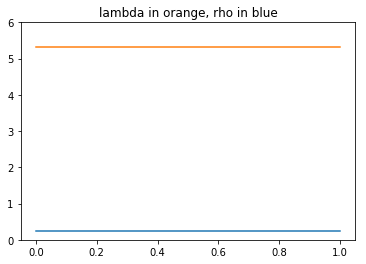

In [8]:
### Test 2:
rho_2 = [0.25 for _ in x_values]
result_2 = invert_densities(1, rho_2, 0.25)   # The 0.75 here acts as rho_1_positive in contrived example.
print("alpha = " + str(result_2[0]))
print("beta = " + str(result_2[1]))
print("regime is " + str(determine_regime(1, rho_2)))
lambda_vec = result_2[2]
plt.plot(x_values, rho_2)
plt.plot(x_values, lambda_vec)
plt.title('lambda in orange, rho in blue')
axes = plt.gca()   # gca = get current axes
axes.set_ylim([0,6])

alpha = 4.0
beta = 4.0
regime is 3


(0, 6)

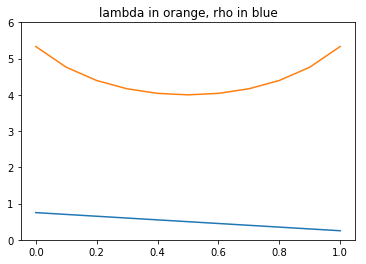

In [9]:
### Test 3:
rho_3 = [(0.75 - x/2) for x in x_values]
result_3 = invert_densities(1, rho_3, 0.25)   # 0.25 here acts as rho_1_positive in contrived example.
print("alpha = " + str(result_3[0]))
print("beta = " + str(result_3[1]))
print("regime is " + str(determine_regime(1, rho_3)))
lambda_vec = result_3[2]
plt.plot(x_values, rho_3)
plt.plot(x_values, lambda_vec)
plt.title('lambda in orange, rho in blue')
axes = plt.gca()   # gca = get current axes
axes.set_ylim([0,6])

alpha = 1.3333333333333333
beta = 1.3333333333333333
regime is 0


(0, 6)

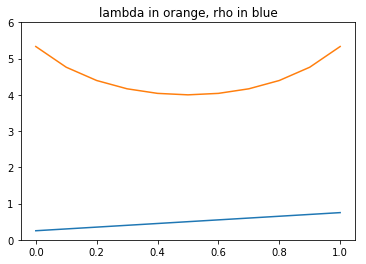

In [10]:
### Test 4:
rho_4 = [(0.25 + x/2) for x in x_values]
result_4 = invert_densities(1, rho_4, 0.75)   # 0.75 here acts as rho_1_positive in contrived example.
print("alpha = " + str(result_4[0]))
print("beta = " + str(result_4[1]))
print("regime is " + str(determine_regime(1,rho_4)))
lambda_vec = result_4[2]
plt.plot(x_values, rho_4)
plt.plot(x_values, lambda_vec)
plt.title('lambda in orange, rho in blue')
axes = plt.gca()   # gca = get current axes
axes.set_ylim([0,6])

Now time for the data analysis!! The following numpy arrays, defined below, will hold the regimes, $\alpha, \beta, \lambda_0, \lambda_1, \lambda_{min}, \alpha^*, \beta^*, \rho, x_{min}$ parameters we gather based off of the yeast input data. The data stored in these numpy arrays will be used to plot histograms later.

In [4]:
num_genes = 850
L = 10
regimes = np.zeros(num_genes)   # An array of 850 elems where 0 = error, 1 = LD, 2 = HD, 3 = MC
alphas = np.zeros(num_genes)   # Alpha values
betas = np.zeros(num_genes)   # Beta values
lambda_nots = np.zeros(num_genes)   # lambda_0 values
lambda_ones = np.zeros(num_genes)   # lambda_1 values
lambda_mins = np.zeros(num_genes)   # lambda_min values
alpha_stars = np.zeros(num_genes)   # alpha_star values
beta_stars = np.zeros(num_genes)   # beta_star values
lambda_vecs = [None] * num_genes   # a 2D array, with each entry corresponding to a lambda vec np array
x_mins = np.zeros(num_genes)   # location along transcript where elongation rate lowest
normalized_rho_vectors = [None] * num_genes   # list of np arrays holding normalized rho vectors

In [5]:
# CAUTION: This cell takes a long time (about a minute) to run.
table_1 = pd.read_excel('Yeast Input Data.xlsx', sheet_name = 'Table 1')
table_2 = pd.read_excel('Yeast Input Data.xlsx', sheet_name = 'Table 2')

In [6]:
### Extracting Table 1 Data: Simulated Average Full Densities
table_1_values = np.asarray(table_1['Simulated_Average_full_density'])

Now that we have some global variables defined, we call the extract_rho_vector() and extract_params() function below on all 850 of the genes provided within the table.

In [7]:
def extract_rho_vector(gene_index, L = 10):
    """Return the normalized rho vector from the yeast data set for a particular gene index. """
    row_index = (gene_index * 7) + 4  # pd implicitly considers top row of sheet as column names, not data
    raw_rho_vector = table_2.loc[row_index].values   # harvest raw codon strings
    raw_rho_vector = np.asarray(list(filter(lambda c: c == c, raw_rho_vector)))   # filter out nans
    raw_rho_vector = raw_rho_vector.astype(float)
    
    # Normalizing the raw rho values from Table 2
    gene_length = len(raw_rho_vector)
    # The variable R_g gives the total number of ribosomes on the transcript
    R_g = table_1_values[gene_index] * gene_length / 100
    # The variable C_g gives constant factor we should multiply each value in the prelim_rho_vector by to get true density
    C_g = sum(raw_rho_vector) / R_g
    raw_rho_vector = raw_rho_vector / C_g
    rho_1_positive = raw_rho_vector[-1]  # rho_1_positive refers to the rho density at the very last codon
    
    # Smoothing out over windows of 10
    true_rho_vec = np.zeros(gene_length - (L-1))   # vector has length gene_length - 9
    for i in range(len(true_rho_vec)):
        true_rho_vec[i] = sum(raw_rho_vector[i:i+(L-1)]) / L   # sum(prelim_rho_vector[i:i+9]) / 10
    normalized_rho_vectors[gene_index] = true_rho_vec
    
    return true_rho_vec, rho_1_positive

In [8]:
def extract_params(gene_index, L = 10):
    """Given gene index, extract key parameters for that gene and store data inside numpy arrays defined earlier."""
    rho_vector, rho_1_positive = extract_rho_vector(gene_index)
    
    # Run Analytics
    regime = determine_regime(L, rho_vector)
    abl = invert_densities(L, rho_vector, rho_1_positive)   # abl stands for alpha,beta,lambda stored in a list
    lambda_vec = abl[2]
    lambda_not = lambda_vec[0]
    lambda_one = lambda_vec[-1]
    lambda_min = min(lambda_vec)
    J_max = lambda_min / ((1 + np.sqrt(L)) ** 2)
    alpha_star_coefs = [-1, lambda_not-(J_max*(L-1)), -J_max*lambda_not]
    alpha_star = min(np.roots(alpha_star_coefs))
    beta_star_coefs = [-1, lambda_one-(J_max*(L-1)), -J_max*lambda_one]
    beta_star = min(np.roots(beta_star_coefs))
    x_min = np.where(lambda_vec == np.amin(lambda_vec))[0][0] / len(rho_vector)  # NOTE: only taking the first index
    
    # Storing data inside numpy arrays
    regimes[gene_index] = regime  
    alphas[gene_index] = abl[0]
    betas[gene_index] = abl[1]
    lambda_vecs[gene_index] = lambda_vec
    lambda_nots[gene_index] = lambda_not
    lambda_ones[gene_index] = lambda_one
    lambda_mins[gene_index] = lambda_min
    alpha_stars[gene_index] = alpha_star
    beta_stars[gene_index] = beta_star
    x_mins[gene_index] = x_min

In [9]:
for i in range(num_genes):
    extract_params(i)

Below we plot histograms of all the data gathered.

Text(0.5, 1.0, 'Regimes of Yeast Data')

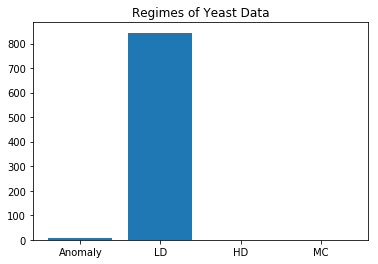

In [33]:
### Plotting Regimes
names = ["Anomaly", "LD", "HD", "MC"]
num_anomalies = len(list(filter(lambda r: r == 0, regimes)))
num_LD = len(list(filter(lambda r: r == 1, regimes)))
num_HD = len(list(filter(lambda r: r == 2, regimes)))
num_MC = len(list(filter(lambda r: r == 3, regimes)))
plt.bar(names, [num_anomalies, num_LD, num_HD, num_MC])
plt.title("Regimes of Yeast Data")

Data analysis from earlier found several genes classified as having an anomalous regime; let us dig deeper and explore why.

In [86]:
### Digging deeper into the anomalies found from earlier:
anomaly_indices = []
for i in range(num_genes):
    if regimes[i] == 0:   # anomaly
        anomaly_indices.append(i)
        
print(anomaly_indices)

def plot_rho(gene_index):
    rho_vector = normalized_rho_vectors[gene_index]
    rho_star = 1 / (10 + np.sqrt(10))
    plt.plot(rho_vector)
    plt.plot([rho_star] * len(rho_vector))
    plt.title("Normalized Rho Vector For Gene " + str(gene_index))

[99, 361, 372, 547, 556, 568]


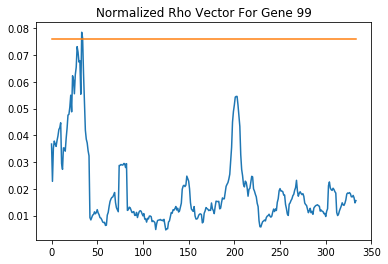

In [187]:
plot_rho(99)

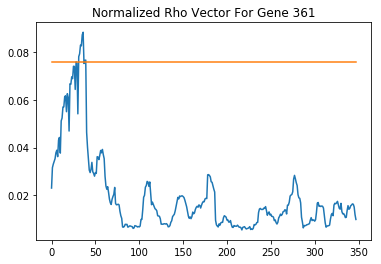

In [188]:
plot_rho(361)

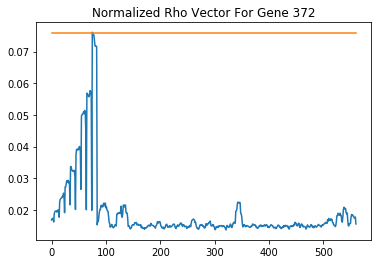

In [189]:
plot_rho(372)

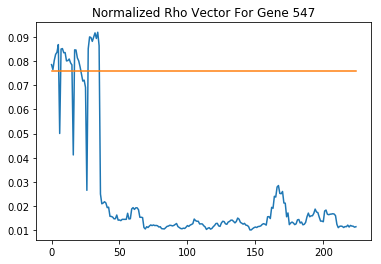

In [190]:
plot_rho(547)

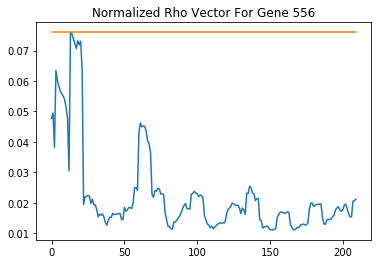

In [191]:
plot_rho(556)

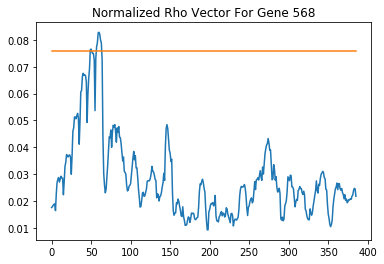

In [192]:
plot_rho(568)

Plotting the $\alpha$ values gathered from the yeast data: Note that since $\alpha$ scales with time, the precise values of $\alpha$ do not carry much significance.

Below that is a plot of $\frac{\alpha}{\alpha^*}$ ratios, where a ratio <1 is characteristic of LD, and >1 is characteristic of HD or MC.

Text(0.5, 1.0, 'Alpha Values of Yeast Data')

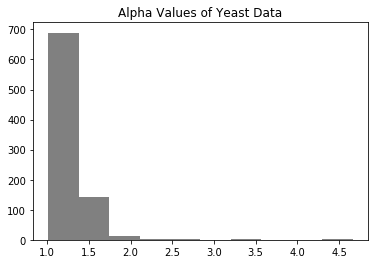

In [37]:
plt.hist(alphas, color = "gray")
plt.title("Alpha Values of Yeast Data")

Text(0.5, 1.0, 'Alpha/Alpha* Ratios of Yeast Data')

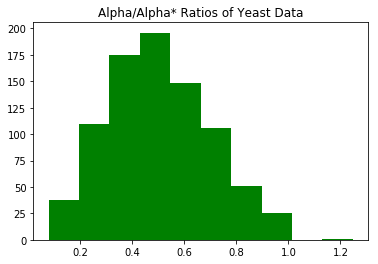

In [194]:
alpha_ratios = alphas / alpha_stars
plt.hist(alpha_ratios, color = "green")
plt.title("Alpha/Alpha* Ratios of Yeast Data")

Plotting the $\beta$ values gathered from the yeast data: Note that since $\beta$ scales with time, the precise values of $\beta$ do not carry much significance.

Below that is a plot of $\frac{\beta}{\beta^*}$ ratios, where a ratio <1 is characteristic of HD, and >1 is characteristic of LD or MC.

Text(0.5, 1.0, 'Beta Values of Yeast Data')

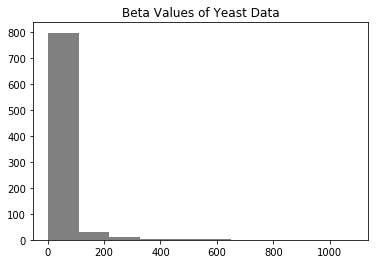

In [39]:
plt.hist(betas, color = "gray") #, bins = [0,25,50,75,100,125,150,175,200])
plt.title("Beta Values of Yeast Data")

Text(0.5, 1.0, 'Beta/Beta* Ratios of Yeast Data')

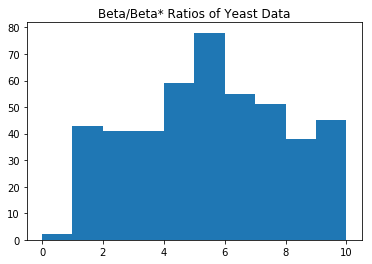

In [193]:
beta_ratios = betas/beta_stars
plt.hist(beta_ratios, bins = [i for i in range(0,11)])
plt.title("Beta/Beta* Ratios of Yeast Data")

Below we are plotting the histogram of $\lambda_0 / \lambda_{min}$ as well as $\lambda_1 / \lambda_{min}$ ratios.

Text(0.5, 1.0, 'Lambda_0 Values of Yeast Data')

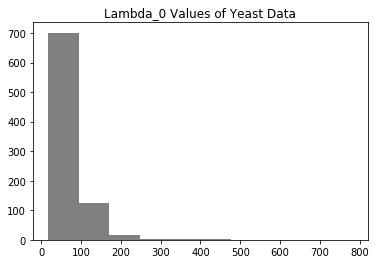

In [49]:
plt.hist(lambda_nots, color = "gray")
plt.title("Lambda_0 Values of Yeast Data")

Text(0.5, 1.0, 'lambda_0/lambda_min Ratios of Yeast Data')

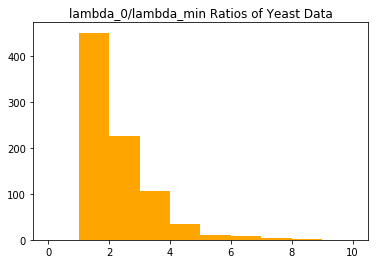

In [52]:
lambda_nots_over_mins = lambda_nots / lambda_mins
plt.hist(lambda_nots_over_mins, color = "orange", bins = [i for i in range(0,11)])
plt.title("lambda_0/lambda_min Ratios of Yeast Data")

Text(0.5, 1.0, 'lambda_1/lambda_min Ratios of Yeast Data')

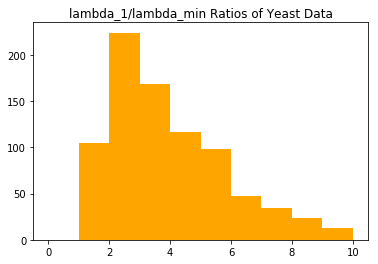

In [55]:
lambda_ones_over_mins = lambda_ones / lambda_mins
plt.hist(lambda_ones_over_mins, color = "orange", bins = [i for i in range(0,11)])
plt.title("lambda_1/lambda_min Ratios of Yeast Data")

In the cell below, index 99 is one of the genes for which the regime was classified as 'anomalous'. Examining the $\alpha$ and $\alpha^*$ values shows that $\alpha$ is just a little smaller than $\alpha^*$, and $\beta$ clearly larger than $\beta^*$, consistent with an LD regime that is very close to transitioning into the MC regime. Most likely, gene 99 is translated MC sometimes and LD other times, so on average it appears to straddle the boundary between these two regimes. It is healthier for yeast to translate their genes in LD, with MC translation becoming activated in response to certain events (ex. stressors) demanding higher protein expression.

In [195]:
# index 99
print('Index 99')
print('alpha: ' + str(alphas[99]))
print('alpha*: ' + str(alpha_stars[99]))
print('beta: ' + str(betas[99]))
print('beta*: ' + str(beta_stars[99]))

Index 99
alpha: 1.5809332918108536
alpha*: 1.581125459074086
beta: 6.866630351866195
beta*: 1.1848795378432133


Similar story for indexes 372, 547, 568. More specifically 372 and 568 appear to tell the story as index 99. Whereas index 547 appears to be clearly in the MC regime due to $\alpha > \alpha^*$ and $\beta > \beta^*$.

In [196]:
# index 372
print('Index 372')
print('alpha: ' + str(alphas[372]))
print('alpha*: ' + str(alpha_stars[372]))
print('beta: ' + str(betas[372]))
print('beta*: ' + str(beta_stars[372]))
print()
# index 547
print('Index 547')
print('alpha: ' + str(alphas[547]))
print('alpha*: ' + str(alpha_stars[547]))
print('beta: ' + str(betas[547]))
print('beta*: ' + str(beta_stars[547]))
print()
# index 568
print('Index 568')
print('alpha: ' + str(alphas[568]))
print('alpha*: ' + str(alpha_stars[568]))
print('beta: ' + str(betas[568]))
print('beta*: ' + str(beta_stars[568]))
print()

Index 372
alpha: 1.2021696516245466
alpha*: 1.202179202243534
beta: 59.25836194532372
beta*: 1.1843658334618632

Index 547
alpha: 4.663738375387922
alpha*: 3.7380082098947502
beta: 13.838900234108635
beta*: 1.1297436479110277

Index 568
alpha: 1.2140826909331977
alpha*: 1.2141656539540315
beta: 10.756582596372162
beta*: 1.2793044448157147



Text(0.5, 1.0, 'x_min values of Yeast Data')

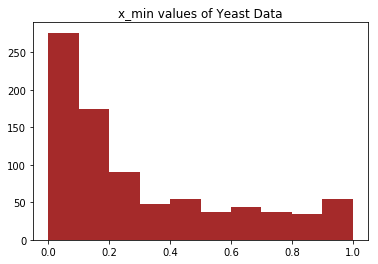

In [205]:
plt.hist(x_mins, color = "brown")
plt.title("x_min values of Yeast Data")

### Part II: Deconvolution

In [15]:
# Construct a list of 61 codons where the codon at index i returns a specific codon string. In alphabetical order.
codon_list = [None] * 61
codon_list[0] = "AAA"
codon_list[1] = "AAC"
codon_list[2] = "AAG"
codon_list[3] = "AAU"
codon_list[4] = "ACA"
codon_list[5] = "ACC"
codon_list[6] = "ACG"
codon_list[7] = "ACU"
codon_list[8] = "AGA"
codon_list[9] = "AGC"
codon_list[10] = "AGG"
codon_list[11] = "AGU"
codon_list[12] = "AUA"
codon_list[13] = "AUC"
codon_list[14] = "AUG"
codon_list[15] = "AUU"
codon_list[16] = "CAA"
codon_list[17] = "CAC"
codon_list[18] = "CAG"
codon_list[19] = "CAU"
codon_list[20] = "CCA"
codon_list[21] = "CCC"
codon_list[22] = "CCG"
codon_list[23] = "CCU"
codon_list[24] = "CGA"
codon_list[25] = "CGC"
codon_list[26] = "CGG"
codon_list[27] = "CGU"
codon_list[28] = "CUA"
codon_list[29] = "CUC"
codon_list[30] = "CUG"
codon_list[31] = "CUU"
codon_list[32] = "GAA"
codon_list[33] = "GAC"
codon_list[34] = "GAG"
codon_list[35] = "GAU"
codon_list[36] = "GCA"
codon_list[37] = "GCC"
codon_list[38] = "GCG"
codon_list[39] = "GCU"
codon_list[40] = "GGA"
codon_list[41] = "GGC"
codon_list[42] = "GGG"
codon_list[43] = "GGU"
codon_list[44] = "GUA"
codon_list[45] = "GUC"
codon_list[46] = "GUG"
codon_list[47] = "GUU"
# UAA is a stop codon
codon_list[48] = "UAC"
# UAG is a stop codon
codon_list[49] = "UAU"
codon_list[50] = "UCA"
codon_list[51] = "UCC"
codon_list[52] = "UCG"
codon_list[53] = "UCU"
# UGA is a stop codon
codon_list[54] = "UGC"
codon_list[55] = "UGG"
codon_list[56] = "UGU"
codon_list[57] = "UUA"
codon_list[58] = "UUC"
codon_list[59] = "UUG"
codon_list[60] = "UUU"

def get_codon_num(codon_string):
    try:
        return codon_list.index(codon_string)
    except ValueError:
        return -1   # stop codon

def get_codon_string(codon_num):
    return codon_list[codon_num]

def T_to_U(dna):
    """Takes in 3-nucleotide sequence of DNA and replaces all Ts with Us."""
    rna_codon = ""
    for i in range(3):
        dna_nt = dna[i]
        if (dna_nt == 'T'): rna_codon = rna_codon + 'U'
        else: rna_codon = rna_codon + dna_nt
    return rna_codon

def missing_codons(codon_seq):
    """Returns a python list of all the codon numbers (0-60) which are absent from the codon sequence passed in."""
    return [c for c in range(61) if c not in codon_seq]

def present_codons(codon_seq):
    """Return sorted list of all the codon numbers (0-60) present within a given codon sequence."""
    return [c for c in range(61) if c in codon_seq]

def codon_freq_plot(gene_index):
    """Graphs, in a stem plot, the total frequency of each codon's appearance for a given gene index."""
    codon_seq = truncated_codon_sequences[gene_index]
    codon_frequencies = [0] * 61
    for c in codon_seq:
        codon_frequencies[c] += 1
    plt.stem(codon_frequencies)
    plt.title("Codon Frequency In Gene " + str(gene_index))
    
def codon_freq_array(gene_index):
    """Returns, in a np array, the total frequency of each codon's appearance for a given gene index."""
    codon_seq = truncated_codon_sequences[gene_index]
    codon_frequencies = [0] * 61
    for c in codon_seq:
        codon_frequencies[c] += 1
    codon_frequencies = np.asarray(codon_frequencies)
    return codon_frequencies

The below function performs the main task of deconvolution, which is the ridge regression. It takes in a vector of $\lambda$ (elongation) values and a np array of codon numbers whose sequence in order represents the transcript. Returns a dictionary holding the site-specific jump rates for each codon that is present within the gene, determined via ridge regression. $\tau$ parameter is also customizable as a parameter being fed into the function.

In [11]:
def ridge_regression(lambda_vec, codon_sequence, tau = 0):
    num_lambda_observations = len(lambda_vec)
    codons_present = present_codons(codon_sequence)   # this list provides mapping from indices to codon numbers
    num_unique_codons = len(codons_present)
    
    # Build an A matrix with 'num_unique_codons' columns (one per codon) and 'num_lambda_observations' rows.
    A = np.zeros((num_lambda_observations, num_unique_codons), dtype = np.int16)
    for i in range(num_lambda_observations):
        local_codons = codon_sequence[i:i+L-1]
        for codon_num in local_codons:
            A[i][codons_present.index(codon_num)] += 1   # map the codon number to its appropriate index
        
    # Construct a b vector, equal to the right hand side of the equality
    b = [lam * L for lam in lambda_vec]
    b = np.asarray(b)
    
    # Solve the linear system using a quadratic programming optimization of ridge (Tikhonov) regression.
    # tau = np.percentile(lambda_vec, 5)   # tau is set to 5th percentile of elongation rates
    P = 2 * (np.dot(A.transpose(),A) + tau * np.identity(num_unique_codons))
    q = 2 * (np.dot(A.transpose(), b))
    G = 1 * np.identity(num_unique_codons)
    h = np.zeros(num_unique_codons)
    ssjr = qp.solve_qp(P, q, G, h)[0]   # ssjr stands for site-specific jump rates
    
    # Construct the dictionary to be returned:
    codon_elongation_rates = dict()
    for i in range(num_unique_codons):
        codon_elongation_rates[codons_present[i]] = ssjr[i]   # convert mappings back appropriately
    
    return codon_elongation_rates

In [208]:
import qpsolvers as qpp

In [209]:
def ridge_regression_diff(lambda_vec, codon_sequence, tau = 0):
    num_lambda_observations = len(lambda_vec)
    codons_present = present_codons(codon_sequence)   # this list provides mapping from indices to codon numbers
    num_unique_codons = len(codons_present)
    
    # Build an A matrix with 'num_unique_codons' columns (one per codon) and 'num_lambda_observations' rows.
    A = np.zeros((num_lambda_observations, num_unique_codons), dtype = np.int16)
    for i in range(num_lambda_observations):
        local_codons = codon_sequence[i:i+L-1]
        for codon_num in local_codons:
            A[i][codons_present.index(codon_num)] += 1   # map the codon number to its appropriate index
        
    # Construct a b vector, equal to the right hand side of the equality
    b = [lam * L for lam in lambda_vec]
    b = np.asarray(b)
    
    # Solve the linear system using a quadratic programming optimization of ridge (Tikhonov) regression.
    # tau = np.percentile(lambda_vec, 5)   # tau is set to 5th percentile of elongation rates
    P = 2 * (np.dot(A.transpose(),A) + tau * np.identity(num_unique_codons))
    q = -2 * (np.dot(A.transpose(), b))
    G = -1 * np.identity(num_unique_codons)
    h = np.zeros(num_unique_codons)
    ssjr = qpp.solve_qp(P, q, G, h)   # ssjr stands for site-specific jump rates
    
    # Construct the dictionary to be returned:
    codon_elongation_rates = dict()
    for i in range(num_unique_codons):
        codon_elongation_rates[codons_present[i]] = ssjr[i]   # convert mappings back appropriately
    
    return codon_elongation_rates

Before we can perform any deconvolution, we need to load up the codon sequences for all 850 yeast genes. The below code does that.

In [12]:
# CAUTION: This cell takes a long time (about a minute) to run.
table_2 = pd.read_excel('Yeast Input Data.xlsx', sheet_name = 'Table 2', dtype = str)

C:\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [16]:
codon_sequences = [None] * num_genes

def extract_codon_sequences():
    for gene_index in range(num_genes):
        row_index = gene_index * 7   # pd implicitly considers top row as column names, not data
        codon_seq = table_2.loc[row_index].values   # harvest raw codon strings
        codon_seq = list(filter(lambda c: c == c, codon_seq))   # filter out nans
        codon_seq = list(map(lambda c: get_codon_num(T_to_U(c)), codon_seq))   # convert to codon numbers
        codon_seq = np.asarray(codon_seq)   # convert to np array
        codon_seq = np.delete(codon_seq, -1)   # chop off last stop codon
        codon_sequences[gene_index] = codon_seq
        
extract_codon_sequences()

truncated_codon_sequences = [None] * num_genes

for i in range(num_genes):
    truncated_codon_sequences[i] = codon_sequences[i][150:]

Now that we have our codon sequences, let us call our deconvolve method to infer the site specific jump rates for every gene!

Coefficients: 
{0: 35.15306581262463, 1: 107.51061380894365, 2: 42.316127434749816, 5: 243.89899708132452, 9: 0.0, 13: 59.72737206449443, 14: 308.43562998542177, 15: 22.988518733376466, 16: 50.197550060394846, 17: 143.36499721053764, 20: 34.62298204059897, 32: 50.55855177573916, 33: 21.37968121060294, 35: 60.51956541103266, 39: 69.59164570386146, 43: 49.33135020526042, 45: 97.95802183576889, 47: 25.51804010239703, 51: 59.575498546469845, 53: 2.6528235110536613, 55: 155.93325899189486, 56: 6.952829805725832, 57: 243.2867969300946, 58: 3.034688030114412, 59: 7.112052047627273, 60: 71.05315560265605}


Text(0.5, 1.0, 'unnormalized codon elongation rates for gene 0')

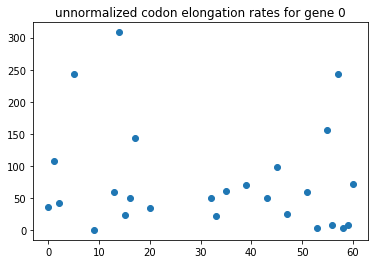

In [34]:
# Investigating site specific jump rates for gene sequence 0:
ssjr_0 = ridge_regression(lambda_vecs[0][150:], truncated_codon_sequences[0], 0)
print("Coefficients: ")
print(ssjr_0)
plt.scatter(list(ssjr_0.keys()), list(ssjr_0.values()))
plt.title("unnormalized codon elongation rates for gene 0")

Now to investigate the impact of using different tau values - specifically we will try out 0, 0.1, 1, 100, 1000.

Text(0.5, 1.0, 'unnormalized codon elongation rates for gene 0 w/ different choices of tau')

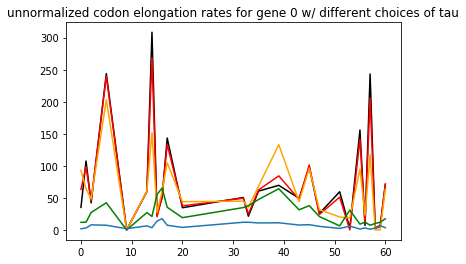

In [35]:
dict_0 = ridge_regression(lambda_vecs[0][150:], truncated_codon_sequences[0], 0)
dict_point_1 = ridge_regression(lambda_vecs[0][150:], truncated_codon_sequences[0], 0.1)
dict_1 = ridge_regression(lambda_vecs[0][150:], truncated_codon_sequences[0], 1)
dict_100 = ridge_regression(lambda_vecs[0][150:], truncated_codon_sequences[0], 100)
dict_1000 = ridge_regression(lambda_vecs[0][150:], truncated_codon_sequences[0], 1000)

plt.plot(dict_0.keys(), dict_0.values(), color = 'black')
plt.plot(dict_point_1.keys(), dict_point_1.values(), color = 'red')
plt.plot(dict_1.keys(), dict_1.values(), color = 'orange')
plt.plot(dict_100.keys(), dict_100.values(), color = 'green')
plt.plot(dict_1000.keys(), dict_1000.values())
plt.title("unnormalized codon elongation rates for gene 0 w/ different choices of tau")

Coefficients: 
{0: 198.76716073588824, 1: 253.97017619936457, 2: 97.85798820625779, 3: 164.86319941815148, 4: 126.19462502555382, 5: 701.0533562699677, 6: -8.049391486968089e-15, 7: 102.12056788800689, 8: 2.2800298816804682e-14, 9: 1.2198905539251648e-13, 10: -7.554897514237401e-16, 11: 45.96530541577602, 12: 124.21182310434826, 13: 127.47619950578385, 14: 9.896069631771613, 15: 92.2967001036323, 16: 59.91273562548502, 17: -2.698759839248953e-16, 18: -2.9934792852911037e-16, 19: -7.191543158201838e-14, 20: 107.89105857565433, 21: 408.96590656700374, 22: 1.1051481883021725e-13, 23: 144.2203415010023, 27: 236.21247970356086, 28: 463.55658943739775, 29: 311.5543477537473, 30: 42.613621098748446, 31: 217.71954572725, 32: -1.2927223365183071e-14, 33: 3.073277047134537e-14, 34: -8.352175747663322e-16, 35: 57.70664079764954, 36: -3.533268868104988e-14, 37: 7.347108108894882e-15, 38: 12.621153687809024, 39: 153.95822477243794, 40: 3.85905040831479e-14, 41: 169.44895264951492, 42: 386.131581116

Text(0.5, 1.0, 'unnormalized codon elongation rates for gene 2')

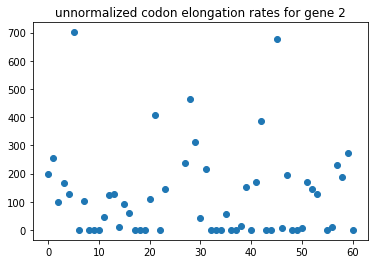

In [36]:
# Investigating site specific jump rates for gene sequence 2:
ssjr_2 = ridge_regression(lambda_vecs[2][150:], truncated_codon_sequences[2], 0)
print("Coefficients: ")
print(ssjr_2)
plt.scatter(list(ssjr_2.keys()), list(ssjr_2.values()))
plt.title("unnormalized codon elongation rates for gene 2")

Text(0.5, 1.0, 'unnormalized codon elongation rates for gene 2 w/ different choices of tau')

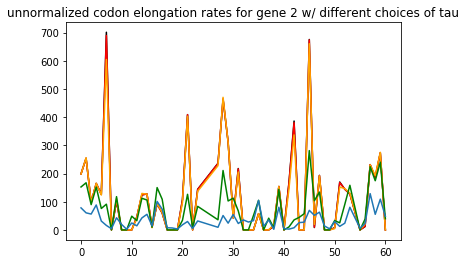

In [37]:
dict_0 = ridge_regression(lambda_vecs[2][150:], truncated_codon_sequences[2], 0)
dict_point_1 = ridge_regression(lambda_vecs[2][150:], truncated_codon_sequences[2], 0.1)
dict_1 = ridge_regression(lambda_vecs[2][150:], truncated_codon_sequences[2], 1)
dict_100 = ridge_regression(lambda_vecs[2][150:], truncated_codon_sequences[2], 100)
dict_1000 = ridge_regression(lambda_vecs[2][150:], truncated_codon_sequences[2], 1000)

plt.plot(dict_0.keys(), dict_0.values(), color = 'black')
plt.plot(dict_point_1.keys(), dict_point_1.values(), color = 'red')
plt.plot(dict_1.keys(), dict_1.values(), color = 'orange')
plt.plot(dict_100.keys(), dict_100.values(), color = 'green')
plt.plot(dict_1000.keys(), dict_1000.values())
plt.title("unnormalized codon elongation rates for gene 2 w/ different choices of tau")

The matrix below is going to hold the unnormalized codon elongation rates derived for every one of the 850 genes. More specifically it will be a list holding 850 dictionaries, with each dictionary of codon elongation rates being derived from the deconvolution procedure for one of the genes.

Importantly, we are also only going to analyze the tails of the genes; i.e. all codons appearing after position 150. 

In [38]:
# CAUTION: This cell takes a little while longer (~30 seconds) to run.
unnormalized_codon_elong_rates = [None] * num_genes

for i in range(num_genes):
    lambda_vec = (lambda_vecs[i])[150:]
    codon_seq = truncated_codon_sequences[i]
    ssjr_dict = ridge_regression(lambda_vec, codon_seq, 0)
    unnormalized_codon_elong_rates[i] = ssjr_dict

To investigate whether there's any correlation btwn the frequency with which a codon appears in a gene, and whether or not it has a nonzero elongation rate.

We will be following the correlation scheme to correlate a categorical variable with a continuous variable as detailed from the Wikipedia page below:
https://en.wikipedia.org/wiki/Correlation_ratio

In [156]:
codon_frequencies_absolute = np.zeros((850,61))   # counts absolute number of appearances
codon_frequencies_relative = np.zeros((850,61))   # divides above by number of codons inside the gene sequence

for g in range(num_genes):
    codon_seq = truncated_codon_sequences[g]
    seq_length = len(codon_seq)
    for c in codon_seq:
        codon_frequencies_absolute[g][c] += 1
    for c in range(61):
        codon_frequencies_relative[g][c] = codon_frequencies_absolute[g][c] / seq_length

In [157]:
zero_codon_frequencies = []
nonzero_codon_frequencies = []

for g in range(num_genes):
    dict_sol = unnormalized_codon_elong_rates[g]
    codon_frequencies = codon_frequencies_absolute[g]
    for c in dict_sol:
        if dict_sol[c] > 1e-5:
            nonzero_codon_frequencies.append(codon_frequencies[c])
        else:
            zero_codon_frequencies.append(codon_frequencies[c])

In [159]:
# Calculating the correlation coefficient for absolute codon frequency
z_mean = np.mean(zero_codon_frequencies)
n_mean = np.mean(nonzero_codon_frequencies)
all_codon_frequencies = zero_codon_frequencies + nonzero_codon_frequencies
overall_mean = np.mean(all_codon_frequencies)
z_quantity = len(zero_codon_frequencies)
n_quantity = len(nonzero_codon_frequencies)

numerator = z_quantity*((z_mean - overall_mean) ** 2) + n_quantity*((n_mean - overall_mean) ** 2)
denominator = sum([(cf - overall_mean)**2 for cf in all_codon_frequencies])
eta_squared = numerator / denominator
eta = np.sqrt(eta_squared)
print("Correlation coefficient when examining absolute coefficient frequency")
print(eta)

Correlation coefficient when examining absolute coefficient frequency
0.15203074301967412


In [160]:
zero_codon_frequencies = []
nonzero_codon_frequencies = []

for g in range(num_genes):
    dict_sol = unnormalized_codon_elong_rates[g]
    codon_frequencies = codon_frequencies_relative[g]
    for c in dict_sol:
        if dict_sol[c] > 1e-5:
            nonzero_codon_frequencies.append(codon_frequencies[c])
        else:
            zero_codon_frequencies.append(codon_frequencies[c])

# Calculating the correlation coefficient for relative codon frequency
z_mean = np.mean(zero_codon_frequencies)
n_mean = np.mean(nonzero_codon_frequencies)
all_codon_frequencies = zero_codon_frequencies + nonzero_codon_frequencies
overall_mean = np.mean(all_codon_frequencies)
z_quantity = len(zero_codon_frequencies)
n_quantity = len(nonzero_codon_frequencies)

numerator = z_quantity*((z_mean - overall_mean) ** 2) + n_quantity*((n_mean - overall_mean) ** 2)
denominator = sum([(cf - overall_mean)**2 for cf in all_codon_frequencies])
eta_squared = numerator / denominator
eta = np.sqrt(eta_squared)
print("Correlation coefficient when examining relative coefficient frequency")
print(eta)

Correlation coefficient when examining relative coefficient frequency
0.1869331343805173


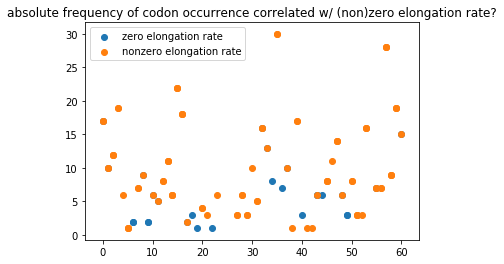

In [155]:
def plot_frequency_correlation_absolute(gene_indices):
    """The graph plots data for every gene index appearing within the list gene_indices."""
    zero_codons, nonzero_codons = [], []
    for g in gene_indices:
        dict_sol = unnormalized_codon_elong_rates[g]
        zero_codons.extend([i for i in dict_sol if dict_sol[i] < 1e-5])
        nonzero_codons.extend([i for i in dict_sol if dict_sol[i] > 1e-5])
    plt.scatter(zero_codons, [codon_frequencies_absolute[g][z] for z in zero_codons], label = 'zero')
    plt.scatter(nonzero_codons, [codon_frequencies_absolute[g][z] for z in nonzero_codons], label = 'nonzero')
    plt.legend(["zero elongation rate", "nonzero elongation rate"])
    plt.title("absolute frequency of codon occurrence correlated w/ (non)zero elongation rate?")

plot_frequency_correlation_absolute([0,1,2])

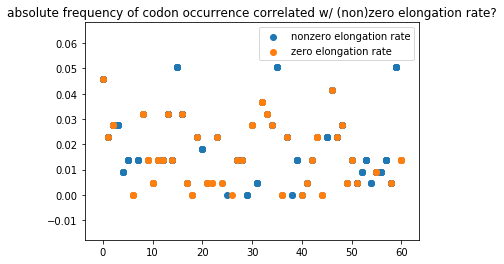

In [154]:
def plot_frequency_correlation_relative(gene_indices):
    """The graph plots data for every gene index appearing within the list gene_indices."""
    zero_codons, nonzero_codons = [], []
    for g in gene_indices:
        dict_sol = unnormalized_codon_elong_rates[g]
        zero_codons.extend([i for i in dict_sol if dict_sol[i] < 1e-5])
        nonzero_codons.extend([i for i in dict_sol if dict_sol[i] > 1e-5])
    plt.scatter(nonzero_codons, [codon_frequencies_relative[g][z] for z in nonzero_codons], label = 'nonzero')
    plt.scatter(zero_codons, [codon_frequencies_relative[g][z] for z in zero_codons], label = 'zero')
    plt.legend(["nonzero elongation rate", "zero elongation rate"])
    plt.title("absolute frequency of codon occurrence correlated w/ (non)zero elongation rate?")
    
plot_frequency_correlation_relative([0,1,2,3,4,5])

The function below applies a filter to clear out dictionary entries mapping to noise that arises from coefficients with assigned values smaller than $10 ^ {-5}$ (floating point error).

In [21]:
def noise_filtration(unnormalized_codon_elong_rates):
    for g in range(num_genes):
        unnormalized_rates = unnormalized_codon_elong_rates[g]
        indices_to_remove = []
        for c in unnormalized_rates:
            if unnormalized_rates[c] < 1e-5:   
                indices_to_remove.append(c)
        for i in indices_to_remove:
            del unnormalized_rates[i]
            
# noise_filtration(unnormalized_codon_elong_rates)

### Part III: Normalization

Below we are going to implement an algorithm for greedy normalization. The procedure is as follows: keep track of a list of codons whose elongation rates have not yet been normalized. While there are still codons lacking a normalized elongation rate, at every iteration greedily select the codon $c$ which has the smallest variance in its normalized estimate. (For the first iteration, we set $c$ = the initial_codon parameter passed in). Then, update all the estimated normalized elongation rates for every codon by normalizing elongation rates in all the genes where codon $c$ appears. Return a list of 61 normalized elongation rates indexed by codon number. Finally, normalize all the returned rates such that the median greedy-normalized elongation rate equals to 1.

The formula for normalization is as follows: given codon A having 'true' (normalized) elongation rate $\hat{r}_A$, and codon B having 'true' (normalized) elongation rate $\hat{r}_B$, if both codons A and B show up in a certain gene having unnormalized rates $r_A$ and $r_B$ respectively, then we can set up the proportion: 

$$ \frac{\hat{r}_A}{r_A} = \frac{\hat{r}_B}{r_B} $$

Thus if $\hat{r}_A$ is given to us from previous estimates, we can calculate $\hat{r}_B = \frac{r_B \hat{r}_A}{r_A}$. In the final step, we will normalize the returned coefficients once more to ensure that the normalized elongation rate of codon 0 is equal to 1, as this will facilitate comparison of results amongst starting with different initial codons.

In [17]:
def custom_std(lst):
    """A small helper function required by greedy normalization that returns np.infty on empty lists."""
    if not lst:
        return np.infty
    return np.std(lst)

In [18]:
def greedy_normalization(unnormalized_codon_elong_rates, initial_codon):
    """Takes in matrix of unnormalized codon elongation rates as well as an inital codon with which to begin the 
    normalization procedure. Returns a np array of normalized codon elongation rates. """
    normalized_elong_rates = np.zeros(61)   # This np array is what we will eventually return
    normalized_elong_rates[initial_codon] = 1
    still_to_normalize = set(range(61))   # This set of codons keeps track of which codons still need to be normalized
    still_to_normalize.remove(initial_codon)
    normalized_estimates = [[] for i in range(61)]   # This list of lists will hold normalized rate estimates for each codon
    current_codon = initial_codon
    current_elong_rate = 1
    
    while len(still_to_normalize) > 0:
        for g in range(num_genes):
            unnormalized_rates = unnormalized_codon_elong_rates[g]
            if current_codon not in unnormalized_rates:   # skip genes lacking data on current_codon
                continue
            for c in still_to_normalize:
                if c in unnormalized_rates:
                    new_elong_estimate = unnormalized_rates[c] * current_elong_rate / unnormalized_rates[current_codon]
                    normalized_estimates[c].append(new_elong_estimate)
        # Pick the codon having the least variance in elongation rate estimates to proceed in the next iteration
        min_variance_codon = min(still_to_normalize, key = lambda x: custom_std(normalized_estimates[x]))
        current_elong_rate = np.median(normalized_estimates[min_variance_codon])
        normalized_elong_rates[min_variance_codon] = current_elong_rate
        current_codon = min_variance_codon
        still_to_normalize.remove(current_codon)

    # Normalize such that the median of the normalized codon elongation rates is equal to 1.
    median_rate = np.median(normalized_elong_rates)
    normalized_elong_rates = normalized_elong_rates / median_rate
    
    return normalized_elong_rates        

In [168]:
def median_deviation(vector):
    """Returns the median absolute deviation of an arbitrary-length vector of elements being passed in."""
    median = np.median(vector)
    diffs = np.abs([v - median for v in vector])
    return np.median(diffs)

### $\tau = 0$

Text(0.5, 1.0, 'Normalized Codon Elongation Rates (beginning w/ codon 0)')

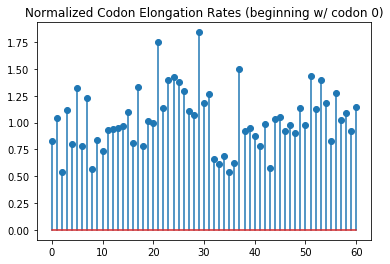

In [225]:
sol_0 = greedy_normalization(unnormalized_codon_elong_rates, 0)
plt.stem(sol_0)
plt.title("Normalized Codon Elongation Rates (beginning w/ codon 0)")

Text(0.5, 1.0, 'Normalized Codon Elongation Rates (beginning w/ codon 1)')

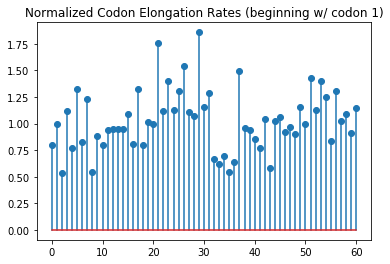

In [165]:
sol_1 = greedy_normalization(unnormalized_codon_elong_rates, 1)
plt.stem(sol_1)
plt.title("Normalized Codon Elongation Rates (beginning w/ codon 1)")

Text(0.5, 1.0, 'ratio of sol_0 vs sol_1 estimates for codon elongation rates')

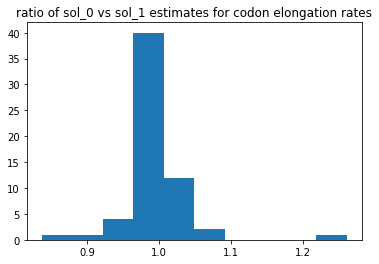

In [166]:
plt.hist([sol_0[c] / sol_1[c] for c in range(61)])
plt.title("ratio of sol_0 vs sol_1 estimates for codon elongation rates")

In [226]:
# CAUTION: This cell takes a while (~3 min) to run.
# The below variable is a np matrix of the normalized elongation rates returned by the greedy normalization procedure.
normalized_elongation_rates = np.zeros((61,61))

# Populate the matrix
for c in range(61):
    normalized_elongation_rates[c] = greedy_normalization(unnormalized_codon_elong_rates, c)

[0.78971936 1.02821896 0.52265526 1.10154846 0.79142367 1.30610732
 0.78038079 1.21680178 0.55735587 0.8295253  0.75017556 0.92633139
 0.92996958 0.93295911 0.94972582 1.08231115 0.79209115 1.31210658
 0.78168145 1.00312782 0.99174608 1.74355607 1.12164958 1.37564513
 1.18522856 1.24449936 1.55279172 1.10617156 1.05843278 1.82961844
 1.13951099 1.25697363 0.66093008 0.6169205  0.6790496  0.5369658
 0.63170951 1.47248405 0.94804884 0.93464591 0.8472285  0.76395443
 1.04070027 0.57237611 1.01024096 1.04220885 0.90750333 0.95724553
 0.88204997 1.13418371 0.97490901 1.41247379 1.10980408 1.38043794
 1.17330637 0.82405156 1.28668596 1.00755277 1.07636193 0.90754001
 1.12754337]


Text(0.5, 1.0, 'Greedy-Normalized Median Codon Elongation Rates (tau = 0)')

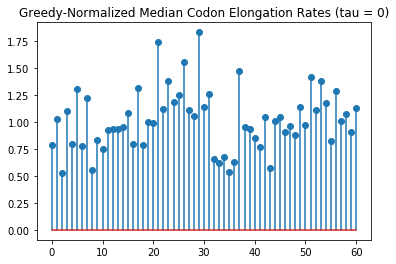

In [227]:
# The below variable shall hold the final, normalized, elongation rates for every codon.
final_codon_elong_rates = np.zeros(61)
# The below variable shall hold the median deviation of normalized elongation rates for every codons.
medev_elong_rates = np.zeros(61)
for c in range(61):
    final_codon_elong_rates[c] = np.median(normalized_elongation_rates[:,c])
    medev_elong_rates = median_deviation(normalized_elongation_rates[:,c])
    
print(final_codon_elong_rates)
plt.stem(final_codon_elong_rates)
plt.title("Greedy-Normalized Median Codon Elongation Rates (tau = 0)")

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 61 Text xticklabel objects>)

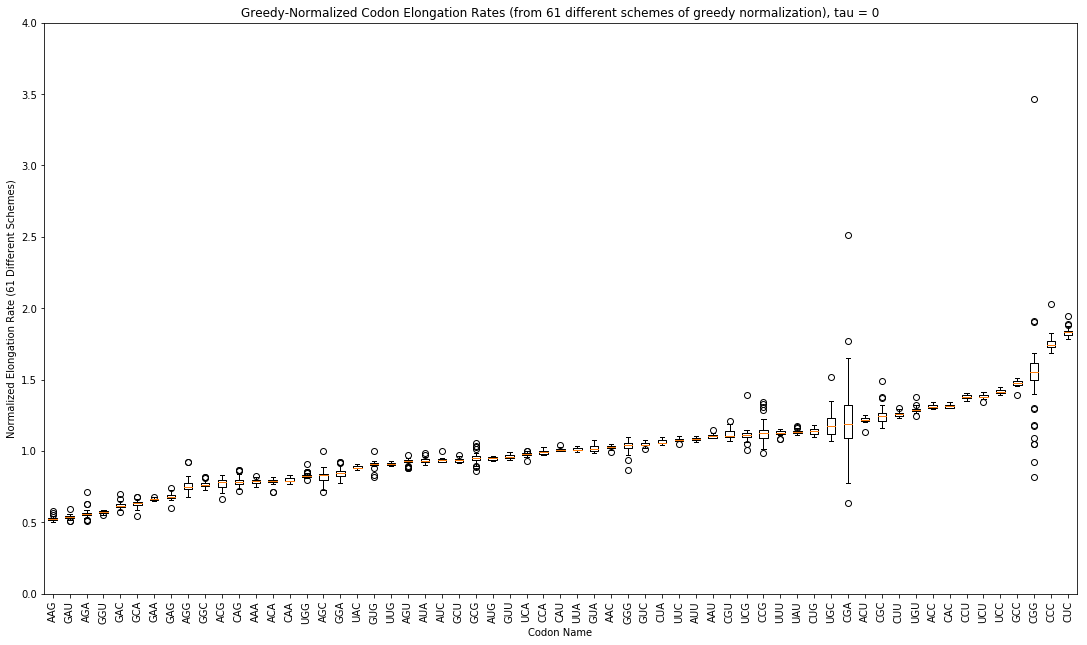

In [228]:
final_rates_sorted_0 = [(c,final_codon_elong_rates[c]) for c in range(61)]
final_rates_sorted_0.sort(key = lambda x: x[1])
codon_strings_sorted_0 = [get_codon_string(t[0]) for t in final_rates_sorted_0]
codon_nums_sorted_0 = [t[0] for t in final_rates_sorted_0]
normalized_rates_0_sorted = np.zeros((61,61))
for i in range(61):
    normalized_rates_0_sorted[:,i] = normalized_elongation_rates[:,codon_nums_sorted_0[i]]

plt.boxplot(normalized_rates_0_sorted, labels = codon_strings_sorted_0)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward = True)
plt.xlabel("Codon Name")
plt.ylabel("Normalized Elongation Rate (61 Different Schemes)")
plt.title("Greedy-Normalized Codon Elongation Rates (from 61 different schemes of greedy normalization), tau = 0")
axes = plt.gca()   # gca = get current axes
axes.set_ylim([0,4])
plt.xticks(rotation=90)

Our next goal will be to examine the effect of different choices of $\tau$ parameter on the normalized codon elongation rates. The below deconvolve() function will roll all of our prior subroutines into a single function. The deconvolve() function will, in the end, return a np array holding 61 entries, corresponding to the final, normalized elongation rate for all 61 codons, as well as the normalized elongation rates over all 61 normalization schemes (in a 61x61 np matrix) for the purposes of making a boxplot.

In [156]:
# CAUTION: This function takes a while to run in general, since it calls a bunch of time-consuming procedures.
def deconvolve(lambda_vecs, truncated_codon_sequences, tau):
    unnormalized_codon_elong_rates = [None] * num_genes
    for g in range(num_genes):
        ssjr_dict = ridge_regression(lambda_vecs[g][150:], truncated_codon_sequences[g], tau)
        unnormalized_codon_elong_rates[g] = ssjr_dict
    noise_filtration(unnormalized_codon_elong_rates)
    normalized_elongation_rates = np.zeros((61,61))
    for c in range(61):
        normalized_elongation_rates[c] = greedy_normalization(unnormalized_codon_elong_rates, c)
    final_codon_elong_rates = np.zeros(61)
    for c in range(61):
        final_codon_elong_rates[c] = np.median(normalized_elongation_rates[:,c])
    return final_codon_elong_rates, normalized_elongation_rates

### $\tau = 0.1$

In [180]:
# CAUTION: This cell takes a long time (3.5 min) to run.
unnormalized_rates_point_1 = [None] * num_genes
for g in range(num_genes):
    ssjr_dict = ridge_regression(lambda_vecs[g][150:], truncated_codon_sequences[g], 0.1)
    unnormalized_rates_point_1[g] = ssjr_dict
noise_filtration(unnormalized_rates_point_1)
normalized_rates_point_1 = np.zeros((61,61))
for c in range(61):
    normalized_rates_point_1[c] = greedy_normalization(unnormalized_rates_point_1, c)
final_rates_point_1 = np.zeros(61)
for c in range(61):
    final_rates_point_1[c] = np.median(normalized_rates_point_1[:,c])

[0.79309269 1.02417261 0.52576375 1.09875213 0.77993554 1.31450783
 0.78571648 1.22951453 0.55673552 0.84757288 0.74132846 0.92809161
 0.93123909 0.93561786 0.94957951 1.09189413 0.81604734 1.30723046
 0.76043235 1.         0.99380558 1.69637541 1.12287667 1.38564783
 1.13559988 1.22565338 1.49432581 1.10815617 1.05246589 1.76900227
 1.13836278 1.25211273 0.65656579 0.62733479 0.71247599 0.53226537
 0.61289361 1.47242507 0.9352328  0.94790503 0.8301605  0.75713604
 1.05173364 0.58192426 1.02192021 1.04509411 0.90551852 0.96272833
 0.88917473 1.13126207 0.97836748 1.41270702 1.11239537 1.37088067
 1.14147944 0.82919723 1.28727165 1.01347699 1.08010453 0.91966717
 1.13668022]


Text(0.5, 1.0, 'Greedy-Normalized Codon Elongation Rates (tau = 0.1)')

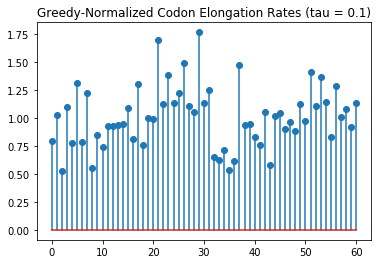

In [181]:
print(final_rates_point_1)
plt.stem(final_rates_point_1)
plt.title("Greedy-Normalized Codon Elongation Rates (tau = 0.1)")

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 61 Text xticklabel objects>)

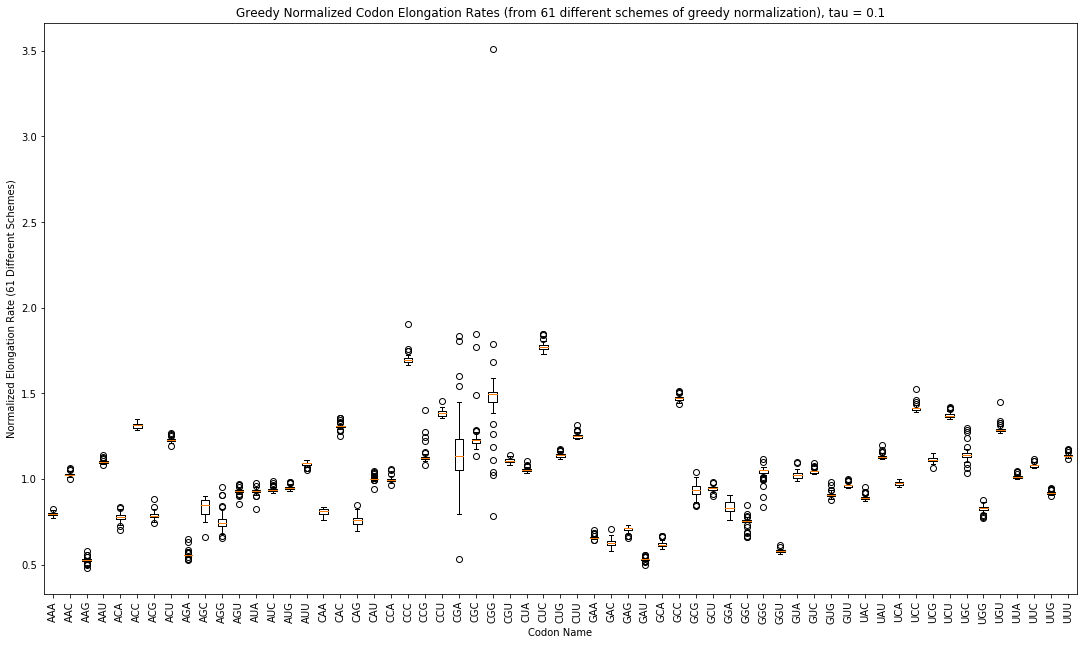

In [182]:
plt.boxplot(normalized_rates_point_1, labels = codon_list)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward = True)
plt.xlabel("Codon Name")
plt.ylabel("Normalized Elongation Rate (61 Different Schemes)")
plt.title("Greedy Normalized Codon Elongation Rates (from 61 different schemes of greedy normalization), tau = 0.1")
axes = plt.gca()   # gca = get current axes
# axes.set_ylim([0,5])
plt.xticks(rotation=90)

### $\tau = 1$

In [183]:
# CAUTION: This cell takes a long time (3.5 min) to run.
unnormalized_rates_1 = [None] * num_genes
for g in range(num_genes):
    ssjr_dict = ridge_regression(lambda_vecs[g][150:], truncated_codon_sequences[g], 0.1)
    unnormalized_rates_1[g] = ssjr_dict
noise_filtration(unnormalized_rates_1)
normalized_rates_1 = np.zeros((61,61))
for c in range(61):
    normalized_rates_1[c] = greedy_normalization(unnormalized_rates_1, c)
final_rates_1 = np.zeros(61)
for c in range(61):
    final_rates_1[c] = np.median(normalized_rates_1[:,c])

[0.79309269 1.02417261 0.52576375 1.09875213 0.77993554 1.31450783
 0.78571648 1.22951453 0.55673552 0.84757288 0.74132846 0.92809161
 0.93123909 0.93561786 0.94957951 1.09189413 0.81604734 1.30723046
 0.76043235 1.         0.99380558 1.69637541 1.12287667 1.38564783
 1.13559988 1.22565338 1.49432581 1.10815617 1.05246589 1.76900227
 1.13836278 1.25211273 0.65656579 0.62733479 0.71247599 0.53226537
 0.61289361 1.47242507 0.9352328  0.94790503 0.8301605  0.75713604
 1.05173364 0.58192426 1.02192021 1.04509411 0.90551852 0.96272833
 0.88917473 1.13126207 0.97836748 1.41270702 1.11239537 1.37088067
 1.14147944 0.82919723 1.28727165 1.01347699 1.08010453 0.91966717
 1.13668022]


Text(0.5, 1.0, 'Greedy-Normalized Codon Elongation Rates (tau = 1)')

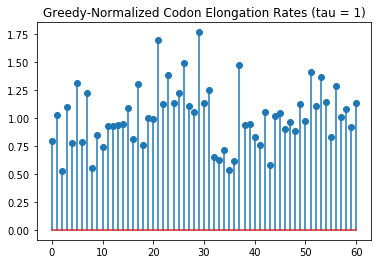

In [198]:
print(final_rates_1)
plt.stem(final_rates_1)
plt.title("Greedy-Normalized Codon Elongation Rates (tau = 1)")

In [195]:
final_rates_1_sorted = [(c,final_rates_1[c]) for c in range(61)]
final_rates_1_sorted.sort(key = lambda x: x[1])
codon_strings_sorted = [get_codon_string(t[0]) for t in final_rates_1_sorted]
# print(codon_strings_sorted)
codon_nums_sorted = [t[0] for t in final_rates_1_sorted]
normalized_rates_1_sorted = np.zeros((61,61))
for i in range(61):
    normalized_rates_1_sorted[:,i] = normalized_rates_1[:,codon_nums_sorted[i]]

['AAG', 'GAU', 'AGA', 'GGU', 'GCA', 'GAC', 'GAA', 'GAG', 'AGG', 'GGC', 'CAG', 'ACA', 'ACG', 'AAA', 'CAA', 'UGG', 'GGA', 'AGC', 'UAC', 'GUG', 'UUG', 'AGU', 'AUA', 'GCG', 'AUC', 'GCU', 'AUG', 'GUU', 'UCA', 'CCA', 'CAU', 'UUA', 'GUA', 'AAC', 'GUC', 'GGG', 'CUA', 'UUC', 'AUU', 'AAU', 'CGU', 'UCG', 'CCG', 'UAU', 'CGA', 'UUU', 'CUG', 'UGC', 'CGC', 'ACU', 'CUU', 'UGU', 'CAC', 'ACC', 'UCU', 'CCU', 'UCC', 'GCC', 'CGG', 'CCC', 'CUC']


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 61 Text xticklabel objects>)

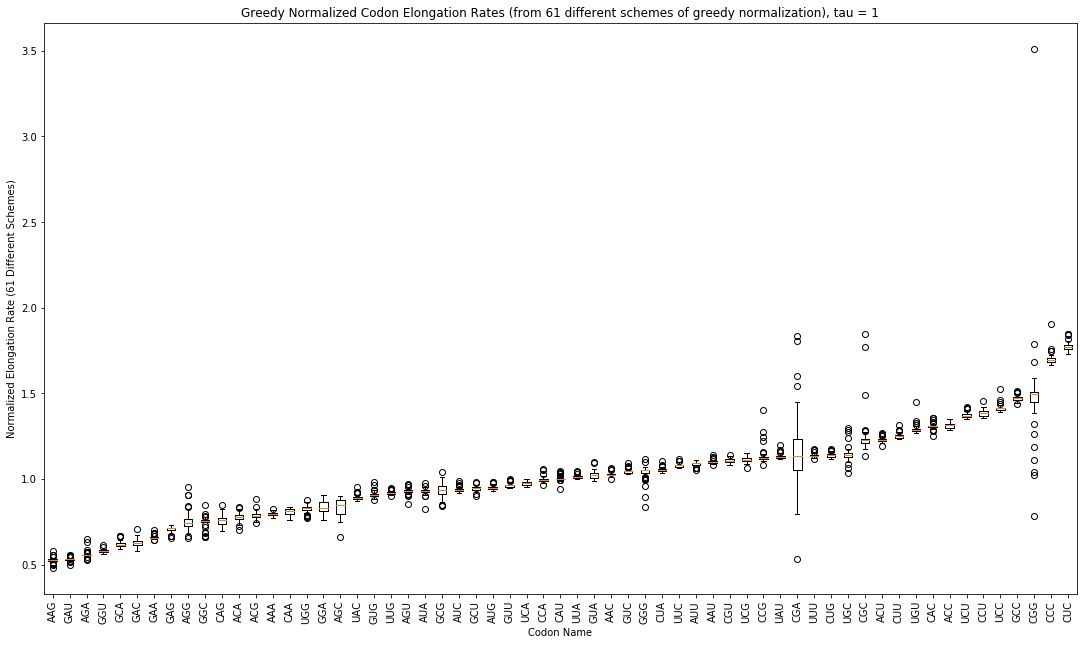

In [197]:
plt.boxplot(normalized_rates_1_sorted, labels= codon_strings_sorted)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward = True)
plt.xlabel("Codon Name")
plt.ylabel("Normalized Elongation Rate (61 Different Schemes)")
plt.title("Greedy Normalized Codon Elongation Rates (from 61 different schemes of greedy normalization), tau = 1")
axes = plt.gca()   # gca = get current axes
# axes.set_ylim([0,2])
plt.xticks(rotation=90)

## Part 3b: Deconvolution Variants (w/ different sequence lengths)

'Holistic' in the variable names below refers to the fact that we are taking the entire lambda vector and codon sequence into consideration in the calculations, without any truncation. 'Sorted' in the variable names below refers to the fact that we are sorting the greedy-normalized codon elongation rates in increasing order. 'Anterior' in the variable names below refers to the fact that we are taking only the first 150 codons of both the lambda vector and codon sequence into consideration in the analysis.

In [22]:
# CAUTION: This cell takes a while (3.5 min) to run.
holistic_unnormalized_rates = [None] * num_genes
for g in range(num_genes):
    ssjr_dict = ridge_regression(lambda_vecs[g], codon_sequences[g], 1)
    holistic_unnormalized_rates[g] = ssjr_dict
noise_filtration(holistic_unnormalized_rates)
holistic_normalized_rates = np.zeros((61,61))
for c in range(61):
    holistic_normalized_rates[c] = greedy_normalization(holistic_unnormalized_rates, c)
holistic_final_rates = np.zeros(61)
for c in range(61):
    holistic_final_rates[c] = np.median(holistic_normalized_rates[:,c])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 61 Text xticklabel objects>)

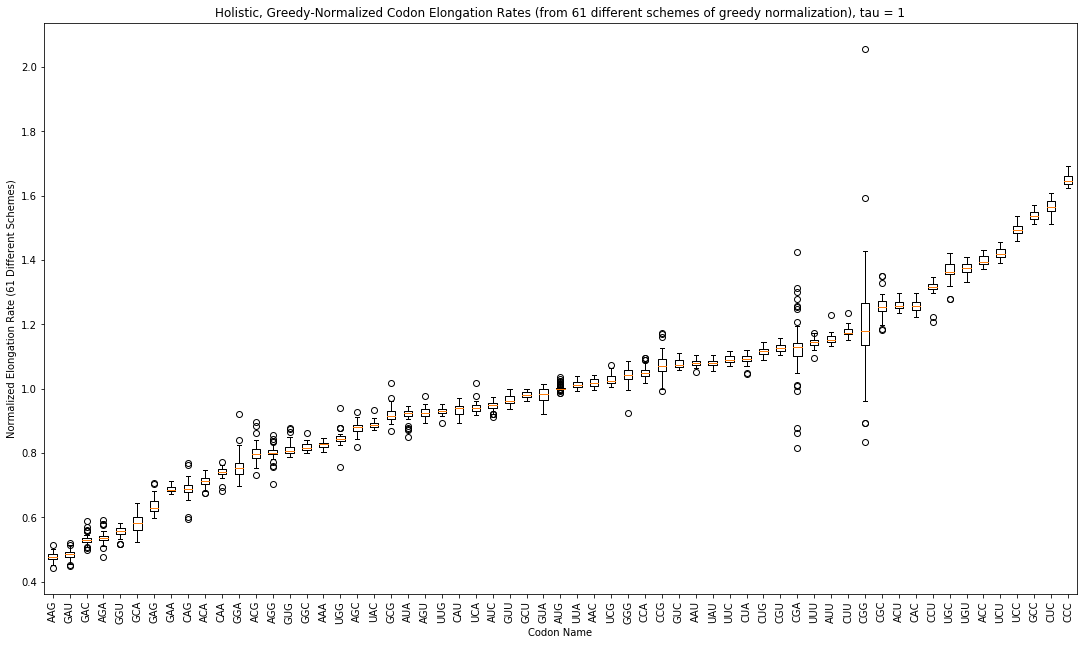

In [31]:
holistic_codon_nums_sorted = list(range(61))
holistic_codon_nums_sorted.sort(key = lambda c: holistic_final_rates[c])   # codon nums in inc. order of elong rate
holistic_codon_strings_sorted = [get_codon_string(c) for c in holistic_codon_nums_sorted]
holistic_normalized_rates_sorted = np.zeros((61,61))
for i in range(61):
    holistic_normalized_rates_sorted[:,i] = holistic_normalized_rates[:,holistic_codon_nums_sorted[i]]
    
plt.boxplot(holistic_normalized_rates_sorted, labels = holistic_codon_strings_sorted)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward = True)
plt.xlabel("Codon Name")
plt.ylabel("Normalized Elongation Rate (61 Different Schemes)")
plt.title("Holistic, Greedy-Normalized Codon Elongation Rates (from 61 different schemes of greedy normalization), tau = 1")
axes = plt.gca()   # gca = get current axes
# axes.set_ylim([0,2])
plt.xticks(rotation=90)

In [25]:
# CAUTION: This cell takes a while (3.5 min) to run.
anterior_unnormalized_rates = [None] * num_genes
for g in range(num_genes):
    ssjr_dict = ridge_regression(lambda_vecs[g][0:150], codon_sequences[g][0:150], 1)
    anterior_unnormalized_rates[g] = ssjr_dict
noise_filtration(anterior_unnormalized_rates)
anterior_normalized_rates = np.zeros((61,61))
for c in range(61):
    anterior_normalized_rates[c] = greedy_normalization(anterior_unnormalized_rates, c)
anterior_final_rates = np.zeros(61)
for c in range(61):
    anterior_final_rates[c] = np.median(anterior_normalized_rates[:,c])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 61 Text xticklabel objects>)

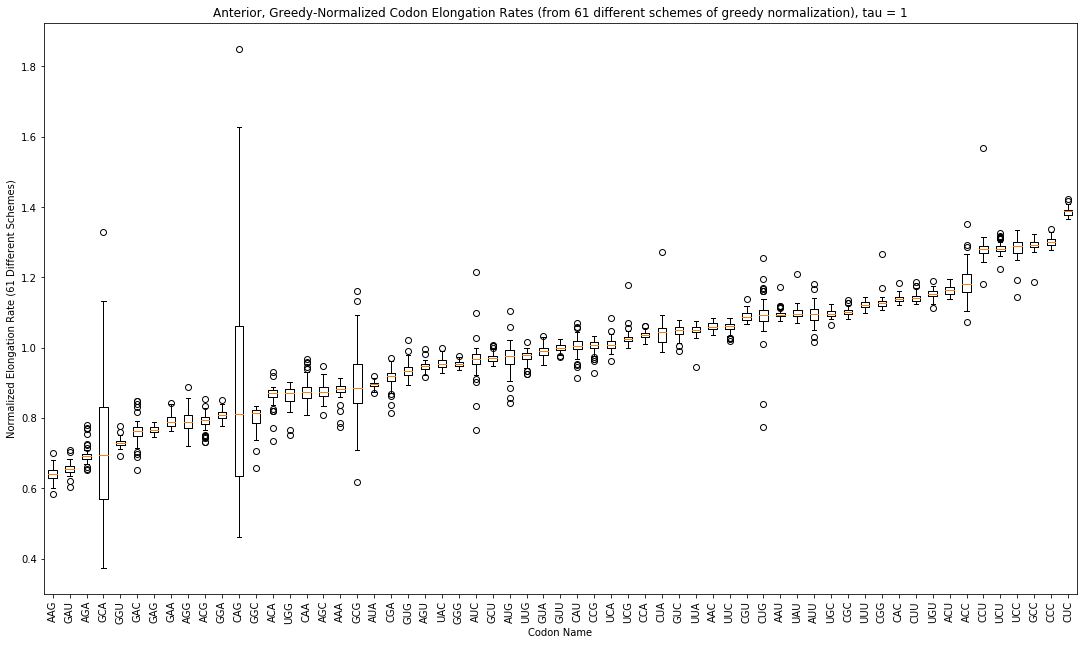

In [32]:
anterior_codon_nums_sorted = list(range(61))
anterior_codon_nums_sorted.sort(key = lambda c: anterior_final_rates[c])   # codon nums in inc. order of elong rate
anterior_codon_strings_sorted = [get_codon_string(c) for c in anterior_codon_nums_sorted]
anterior_normalized_rates_sorted = np.zeros((61,61))
for i in range(61):
    anterior_normalized_rates_sorted[:,i] = anterior_normalized_rates[:,anterior_codon_nums_sorted[i]]
    
plt.boxplot(anterior_normalized_rates_sorted, labels = codon_strings_sorted)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward = True)
plt.xlabel("Codon Name")
plt.ylabel("Normalized Elongation Rate (61 Different Schemes)")
plt.title("Anterior, Greedy-Normalized Codon Elongation Rates (from 61 different schemes of greedy normalization), tau = 1")
axes = plt.gca()   # gca = get current axes
# axes.set_ylim([0,2])
plt.xticks(rotation=90)

In [27]:
# CAUTION: This cell takes a while (3.5 min) to run.
posterior_unnormalized_rates = [None] * num_genes
for g in range(num_genes):
    ssjr_dict = ridge_regression(lambda_vecs[g][150:], codon_sequences[g][150:], 1)
    posterior_unnormalized_rates[g] = ssjr_dict
noise_filtration(posterior_unnormalized_rates)
posterior_normalized_rates = np.zeros((61,61))
for c in range(61):
    posterior_normalized_rates[c] = greedy_normalization(posterior_unnormalized_rates, c)
posterior_final_rates = np.zeros(61)
for c in range(61):
    posterior_final_rates[c] = np.median(posterior_normalized_rates[:,c])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 61 Text xticklabel objects>)

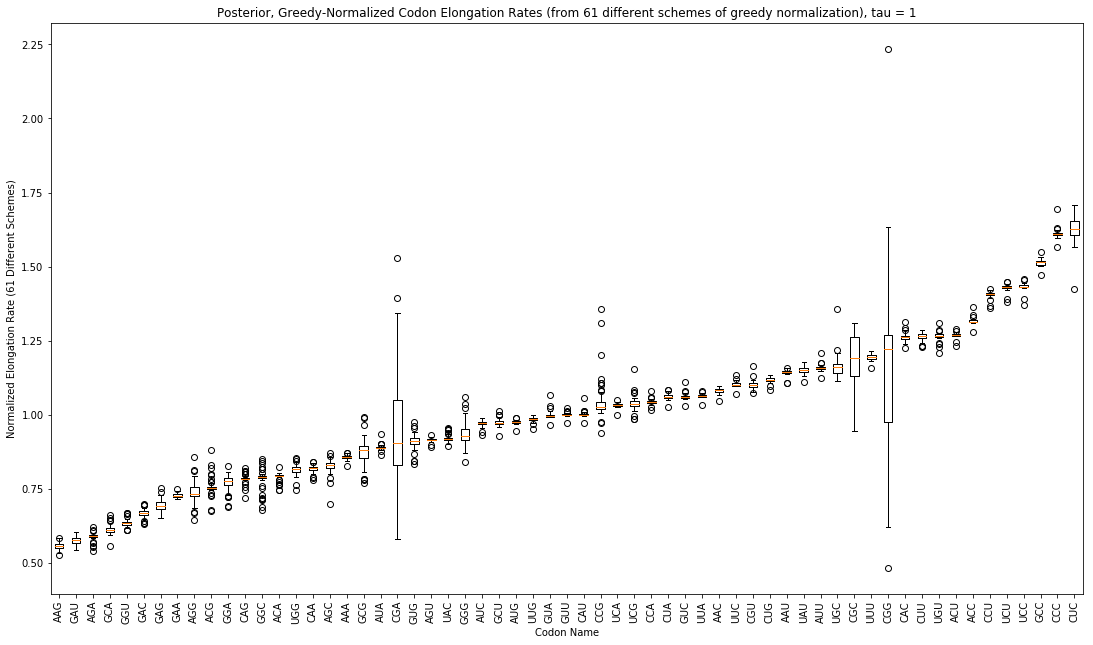

In [33]:
posterior_codon_nums_sorted = list(range(61))
posterior_codon_nums_sorted.sort(key = lambda c: posterior_final_rates[c])   # codon nums in inc. order of elong rate
posterior_codon_strings_sorted = [get_codon_string(c) for c in posterior_codon_nums_sorted]
posterior_normalized_rates_sorted = np.zeros((61,61))
for i in range(61):
    posterior_normalized_rates_sorted[:,i] = posterior_normalized_rates[:,posterior_codon_nums_sorted[i]]
    
plt.boxplot(posterior_normalized_rates_sorted, labels = codon_strings_sorted)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward = True)
plt.xlabel("Codon Name")
plt.ylabel("Normalized Elongation Rate (61 Different Schemes)")
plt.title("Posterior, Greedy-Normalized Codon Elongation Rates (from 61 different schemes of greedy normalization), tau = 1")
axes = plt.gca()   # gca = get current axes
# axes.set_ylim([0,2])
plt.xticks(rotation=90)

In [41]:
print("Sorted Codon Elongation Rates for Entire ORF:")
print(holistic_codon_nums_sorted)
print("Sorted Codon Elongation Rates for first 150 Codons of ORF:")
print(anterior_codon_nums_sorted)
print("Sorted Codon Elongation Rates for tails (codons 150+) of ORF:")
print(posterior_codon_nums_sorted)

Sorted Codon Elongation Rates for Entire ORF:
[2, 35, 33, 8, 43, 36, 34, 32, 18, 4, 16, 40, 6, 10, 46, 41, 0, 55, 9, 48, 38, 12, 11, 59, 19, 50, 13, 47, 39, 44, 14, 57, 1, 52, 42, 20, 22, 45, 3, 49, 58, 28, 30, 27, 24, 60, 15, 31, 26, 25, 7, 17, 23, 54, 56, 5, 53, 51, 37, 29, 21]
Sorted Codon Elongation Rates for first 150 Codons of ORF:
[2, 35, 36, 26, 8, 6, 43, 33, 4, 34, 32, 24, 18, 12, 55, 10, 38, 46, 25, 16, 41, 19, 0, 48, 59, 22, 20, 40, 52, 57, 50, 9, 27, 49, 47, 11, 42, 28, 60, 1, 45, 39, 54, 14, 30, 44, 15, 13, 7, 31, 23, 3, 17, 58, 29, 21, 51, 56, 5, 53, 37]
Sorted Codon Elongation Rates for tails (codons 150+) of ORF:
[2, 35, 8, 36, 43, 33, 34, 32, 10, 6, 40, 18, 41, 4, 55, 16, 9, 0, 38, 12, 24, 46, 11, 48, 42, 13, 39, 14, 59, 44, 47, 19, 22, 50, 52, 20, 28, 45, 57, 1, 58, 27, 30, 3, 49, 15, 54, 25, 60, 26, 17, 31, 56, 7, 5, 23, 53, 51, 37, 21, 29]


In [42]:
print("Sorted Codon Elongation Rates from Publication:")
ref_seq = ['CGG','CGA','CCG','ACG','AGG','UGG','GGG','GCG','GCA','CAG','GGA','GAG','CGC','UCG','ACA','AUA','GUG','UGC','CUG'
          ,'GGC','AGC','CCC','AGA','CUC','GUA','UCA','GGU','GAA','GAC','UAC','CCA','AAG','GAU','AGU','CUA','CGU','CAU','CCU'
          ,'CAC','CUU','AAA','CAA','AUG','UAU','UGU','UUG','GCU','UUA','UCC','UUC','AAU','GUC','AAC','AUC','UUU','GCC','ACU'
          ,'ACC','GUU','UCU','AUU']
ref_seq = [get_codon_num(s) for s in ref_seq]
print(ref_seq)

Sorted Codon Elongation Rates from Publication:
[26, 24, 22, 6, 10, 55, 42, 38, 36, 18, 40, 34, 25, 52, 4, 12, 46, 54, 30, 41, 9, 21, 8, 29, 44, 50, 43, 32, 33, 48, 20, 2, 35, 11, 28, 27, 19, 23, 17, 31, 0, 16, 14, 49, 56, 59, 39, 57, 51, 58, 3, 45, 1, 13, 60, 37, 7, 5, 47, 53, 15]


### Digging Deeper Into Investigating Correlation

In [126]:
unnormalized_codon_elong_rates_1 = [None] * num_genes

for g in range(num_genes):
    ssjr_dict = ridge_regression(lambda_vecs[g][150:], truncated_codon_sequences[g], 1)
    unnormalized_codon_elong_rates_1[g] = ssjr_dict

In [134]:
codon_freq_elong_rate = np.zeros((147,2))   # makes assumption that max codon frequency is 100
# first index of above sublist shall be zero, second index of above sublist shall be nonzero

for g in range(num_genes):
    absolute_appearances = codon_freq_array(g)
    ssjr_dict = unnormalized_codon_elong_rates_1[g]
    for c in range(61):
        if c not in ssjr_dict:
            continue
        elif ssjr_dict[c] < 1e-5:
            codon_freq_elong_rate[absolute_appearances[c]][0] += 1
        else:
            codon_freq_elong_rate[absolute_appearances[c]][1] += 1
            
codon_freq_elong_rate

array([[0.000e+00, 0.000e+00],
       [3.024e+03, 4.729e+03],
       [2.109e+03, 3.850e+03],
       [1.478e+03, 3.253e+03],
       [1.166e+03, 2.669e+03],
       [8.430e+02, 2.166e+03],
       [6.360e+02, 1.830e+03],
       [5.130e+02, 1.502e+03],
       [3.760e+02, 1.320e+03],
       [2.840e+02, 1.114e+03],
       [2.670e+02, 9.540e+02],
       [1.700e+02, 8.080e+02],
       [1.520e+02, 6.490e+02],
       [1.330e+02, 5.650e+02],
       [1.360e+02, 4.860e+02],
       [9.000e+01, 4.440e+02],
       [8.500e+01, 3.580e+02],
       [7.200e+01, 3.070e+02],
       [5.700e+01, 2.890e+02],
       [3.900e+01, 2.360e+02],
       [3.400e+01, 2.290e+02],
       [3.800e+01, 2.060e+02],
       [2.200e+01, 1.940e+02],
       [1.900e+01, 1.360e+02],
       [2.000e+01, 1.300e+02],
       [2.800e+01, 1.190e+02],
       [1.900e+01, 1.050e+02],
       [1.200e+01, 9.300e+01],
       [1.700e+01, 9.000e+01],
       [1.900e+01, 6.700e+01],
       [7.000e+00, 5.600e+01],
       [8.000e+00, 5.800e+01],
       [

<BarContainer object of 30 artists>

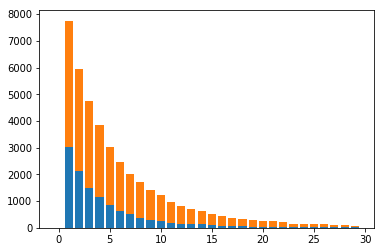

In [140]:
zero_freqs = codon_freq_elong_rate[:,0][:30]
nonzero_freqs = codon_freq_elong_rate[:,1][:30]

plt.bar(range(30), zero_freqs)
plt.bar(range(30), nonzero_freqs, bottom = zero_freqs )

Ok so now we are going to do some sort of statistical test to test whether or not there exists any correlation between absolute codon frequency and whether or not the ridge regression returns a nonzero elongation rate for that codon. Let's start with something like a threshold of 3. We predict that codons which appear with absolute frequency <3 are more likely to have zero elongation rate.

In [144]:
codon_freqs_0 = codon_freq_array(0)
ssjr_dict_0 = ridge_regression(lambda_vecs[0][150:], truncated_codon_sequences[0], 1)
# codons 9,58,59 have zero elongation rate
print(codon_freqs_0[9])
print(codon_freqs_0[58])
print(codon_freqs_0[59])
N = 61
Y_m = sum([1 for c in ssjr_dict_0 if codon_freqs_0[c] < 3])
K = 2 * Y_m
print("K equals: " + str(K))
X = 3   # 3 codons having returned coefficient < 1e-5
ssjr_dict_0

1
1
3
K equals: 34


{0: 93.0309163169628,
 1: 64.08069500563101,
 2: 48.54893808077393,
 5: 202.84011584023358,
 9: -2.702832070448907e-16,
 13: 60.24117600864115,
 14: 151.53072603004128,
 15: 26.770334399898502,
 16: 60.38828304304775,
 17: 105.07823078421639,
 20: 44.021912619516584,
 32: 44.845718069723986,
 33: 35.32116812611458,
 35: 68.16278946991514,
 39: 133.02516581147552,
 43: 44.23008311683796,
 45: 96.19509408369655,
 47: 31.608490682902303,
 51: 20.19802609296345,
 53: 18.669988312409835,
 55: 94.80428681190732,
 56: 23.081191928707984,
 57: 117.44495934947102,
 58: 0.0,
 59: -6.7728348456997065e-18,
 60: 63.26956306538693}

In [200]:
EXP_unnormalized_codon_elong_rates = [None] * num_genes
for g in range(num_genes):
    ssjr_dict = ridge_regression_diff(lambda_vecs[g], truncated_codon_sequences[g], 1)
    EXP_unnormalized_codon_elong_rates[g] = ssjr_dict
noise_filtration(EXP_unnormalized_codon_elong_rates)

'EXP_normalized_elong_rates = np.zeros((61,61))\nfor c in range(61):\n    EXP_normalized_elong_rates[c] = greedy_normalization(EXP_unnormalized_codon_elong_rates, c)\nEXP_final_elong_rates = np.zeros(61)\nfor c in range(61):\n    EXP_final_elong_rates[c] = np.median(EXP_normalized_elong_rates[:,c])'

In [201]:
EXP_normalized_elong_rates = np.zeros((61,61))
for c in range(61):
    EXP_normalized_elong_rates[c] = greedy_normalization(EXP_unnormalized_codon_elong_rates, c)
EXP_final_elong_rates = np.zeros(61)
for c in range(61):
    EXP_final_elong_rates[c] = np.median(EXP_normalized_elong_rates[:,c])

In [205]:
EXP_unnormalized_codon_elong_rates

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},


In [ ]:
plt.boxplot(EXP_normalized_elong_rates, labels= codon_list)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward = True)
plt.xlabel("Codon Number")
plt.ylabel("Normalized Elongation Rate (61 Different Schemes)")
plt.title("EXP Greedy Normalized Codon Elongation Rates (from 61 different schemes of greedy normalization), tau = 1")
axes = plt.gca()   # gca = get current axes
#axes.set_ylim([0, 5])
plt.xticks(rotation=90)

In [215]:
ambipresent = []

for g in range(num_genes):
    codon_seq = truncated_codon_sequences[g]
    if 24 in codon_seq and 26 in codon_seq:
        ambipresent.append(g)
        
print(ambipresent)

[12, 110, 122, 136, 157, 195, 210, 217, 256, 263, 295, 317, 377, 418, 450, 542, 573, 574, 587, 617, 630, 640, 683, 728, 733, 742, 772, 776]


In [221]:
ridge_regression(lambda_vecs[210][150:], truncated_codon_sequences[210], 1)

{0: 127.89253224324888,
 1: 125.94077368430432,
 2: -2.6256352347153954e-15,
 3: 6.854849532804628e-16,
 4: 0.17575858563399496,
 6: 1.984876975597384e-14,
 7: 79.84554972757543,
 8: 27.44384605689018,
 10: 25.271509803888268,
 11: 183.52388397755504,
 12: 51.49975830880279,
 13: 60.947313734735815,
 14: 172.65399145396714,
 15: 197.76941703803416,
 16: -2.6272536302929797e-14,
 17: 1.3693569016697132e-14,
 18: 18.02426296306377,
 19: 28.65957168883126,
 20: 2.0362530468076875e-14,
 23: 227.78600561173468,
 24: -1.1993304028710167e-15,
 25: 158.20609077441853,
 26: 3.599242552274272e-14,
 27: -3.2671186497368577e-15,
 28: 113.09715076804743,
 30: 200.85522680262358,
 31: -1.0054515051887801e-14,
 32: 125.61332627608721,
 33: 76.68658797375326,
 34: -4.3840143857896e-15,
 35: 4.38515754795657,
 36: 2.6346044585514333e-16,
 37: 103.33216745618085,
 38: 5.889422611959232e-14,
 39: 97.29003113076838,
 40: 1.3327362480008335e-13,
 41: 3.457672658918775e-14,
 43: 117.72041475884754,
 45: 65.

### Part IV: Other Scratchwork (Not Immediately Useful)

Text(0.5, 1.0, 'stdev of unnormalized elongation rates for each codon')

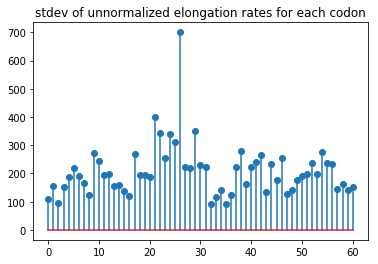

In [66]:
stdev_of_unnormalized_estimates = []
iqr_of_unnormalized_estimates = []
for c in range(61):
    unnormalized_c_jump_rates = [unnormalized_codon_elong_rates[i][c] for i in range(num_genes) \
                                 if c in unnormalized_codon_elong_rates[i]]
    stdev_of_unnormalized_estimates.append((c, np.std(unnormalized_c_jump_rates)))
    iqr_of_unnormalized_estimates.append((c, np.percentile(unnormalized_c_jump_rates,75)- \
                                          np.percentile(unnormalized_c_jump_rates,25)))

plt.stem([s[1] for s in stdev_of_unnormalized_estimates])
plt.title("stdev of unnormalized elongation rates for each codon")

{'whiskers': [<matplotlib.lines.Line2D at 0x25344e5a6d8>,
 'caps': [<matplotlib.lines.Line2D at 0x253446a5d68>,
 'boxes': [<matplotlib.lines.Line2D at 0x253446a55f8>],
 'medians': [<matplotlib.lines.Line2D at 0x2534468c438>],
 'fliers': [<matplotlib.lines.Line2D at 0x2534468c780>],
 'means': []}

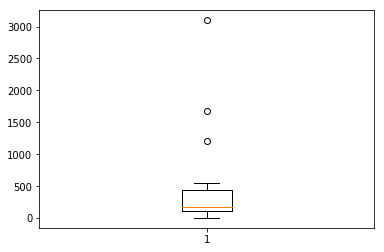

In [69]:
unnormalized_26_jump_rates = [unnormalized_codon_elong_rates[i][26] for i in range(num_genes) if 26 in unnormalized_codon_elong_rates[i]]
plt.boxplot(unnormalized_26_jump_rates)

{'whiskers': [<matplotlib.lines.Line2D at 0x2532d081828>,
 'caps': [<matplotlib.lines.Line2D at 0x2532d079198>,
 'boxes': [<matplotlib.lines.Line2D at 0x2532d0789b0>],
 'medians': [<matplotlib.lines.Line2D at 0x2532d079828>],
 'fliers': [<matplotlib.lines.Line2D at 0x2532d079b70>],
 'means': []}

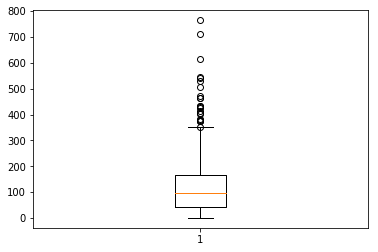

In [100]:
unnormalized_36_jump_rates = [unnormalized_codon_elong_rates[i][36] for i in range(num_genes) if 36 in unnormalized_codon_elong_rates[i]]
plt.boxplot(unnormalized_36_jump_rates)

In [102]:
outlier_indices = []
for g in range(num_genes):
    unnormalized_rates = unnormalized_codon_elong_rates[g]
    if 36 not in unnormalized_rates:
        continue
    if unnormalized_rates[36] > 600:
        outlier_indices.append(g)
        
print(outlier_indices)

[362, 381, 673]


1


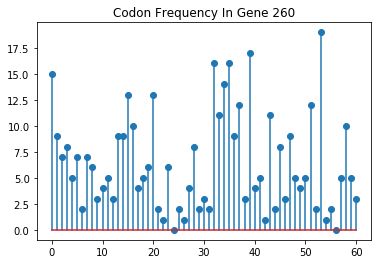

In [110]:
codon_freq(260)
freq_26 = sum([1 for c in truncated_codon_sequences[640] if c == 26])
print(freq_26)

1


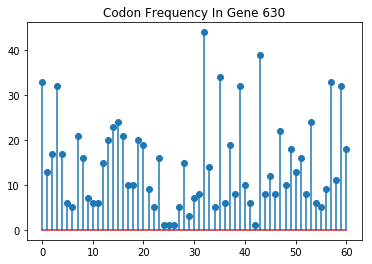

In [109]:
codon_freq(630)
freq_26 = sum([1 for c in truncated_codon_sequences[640] if c == 26])
print(freq_26)

1


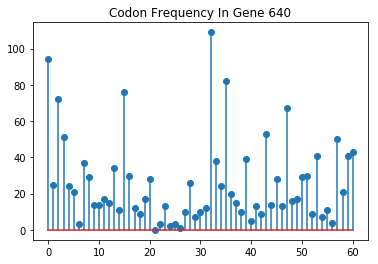

In [108]:
codon_freq(640)
freq_26 = sum([1 for c in truncated_codon_sequences[640] if c == 26])
print(freq_26)

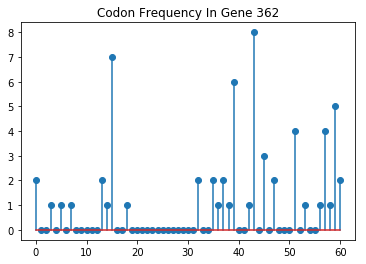

In [103]:
codon_freq(362)

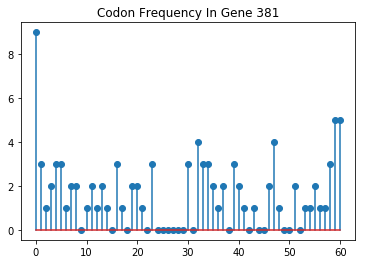

In [104]:
codon_freq(381)

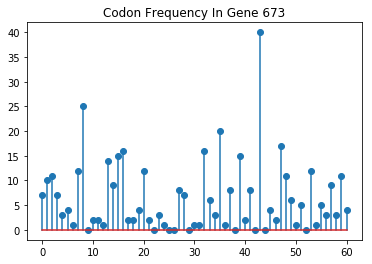

In [106]:
codon_freq(673)

In [43]:
def span_genome(codon_nums):
    """Returns true if any one of the codon numbers from the list codon_nums is present within each of the 850 genes."""
    for codon_seq in truncated_codon_sequences:
        result = any([cn in codon_seq for cn in codon_nums])   # testing presence, OR'ed together
        if not result:
            return False
    return True

From the below cell, it seems that if we added in codons one at a time based upon which ones had the lowest variance (in a greedy fashion), we'd have to add in a whole bunch of codons one at a time before being able to span the entire 'genome'!

In [61]:
iqr_of_unnormalized_estimates.sort(key = lambda x: x[1])
print(iqr_of_unnormalized_estimates)

counter = 0
span = []
while not span_genome(span):
    span.append(iqr_of_unnormalized_estimates[counter][0])
    counter += 1
    
print(span)

[(26, 95.05476921171828), (24, 144.638070184408), (25, 221.11640608571176), (22, 256.7556927979182), (29, 299.64170470390707), (54, 334.38711925551235), (42, 382.7623941325117), (6, 421.95565942380915), (9, 427.1829679525202), (38, 441.09998315677853), (10, 460.5139952821503), (21, 547.6514779381121), (52, 551.2116048797099), (18, 553.0912420765162), (40, 558.6777828716083), (31, 679.6254373194429), (12, 684.4646505443104), (41, 690.2060359726967), (30, 699.3253299256503), (17, 708.8948282498161), (11, 734.7337114443219), (44, 743.1403273101521), (46, 772.5032790918813), (56, 779.7679086302431), (27, 785.3933613422287), (55, 807.6192863460818), (19, 872.1230738644297), (28, 908.1995702359723), (50, 908.89811658951), (4, 945.3367918107831), (36, 984.0852725074793), (23, 1078.2124698981108), (34, 1102.8250815650958), (5, 1113.7554672593017), (45, 1218.2030617046453), (51, 1271.5928952953027), (48, 1290.067945127452), (49, 1337.8311015924592), (14, 1353.057280368737), (33, 1378.9032406122

Now we search for a codon that appears in every gene, for the purposes of normalization. Hopefully, one exists.

In [83]:
ubiquitous_codon = -1
for i in range(61):
    ubi = True
    for i in range(num_genes):
        codon_seq = codon_sequences[i][150:]
        if i not in codon_seq:
            ubi = False
            break
    if ubi:   # found in every gene
        ubiquititous_codon = i
        break

print(ubiquitous_codon)

-1


Well from the above analysis it appears that there does not exist a codon which appears in every gene. Therefore let's conduct a frequency analysis to find out how often each codon appears in the genes. 

Each codon in the below cell is assigned a frequency score, from 0 to 850, depending on in how many genes the codon appears.

[833, 815, 834, 800, 717, 761, 540, 799, 809, 584, 587, 705, 637, 808, 781, 827, 824, 657, 618, 713, 799, 504, 367, 726, 124, 289, 88, 624, 740, 402, 627, 656, 845, 812, 769, 829, 752, 797, 545, 824, 646, 717, 583, 829, 666, 790, 697, 815, 777, 742, 715, 771, 528, 799, 415, 686, 626, 800, 798, 832, 796]


Text(0.5, 1.0, 'Frequency of appearance across all 850 genes for each codon')

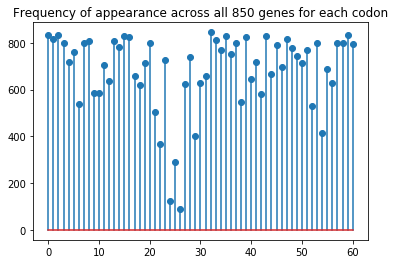

In [90]:
frequency_scores = [0] * 61
for g in range(num_genes):
    codon_seq = codon_sequences[g][150:]
    for c in range(61):
        if c in codon_seq:
            frequency_scores[c] += 1
            
print(frequency_scores)
plt.stem(frequency_scores)
plt.title("Frequency of appearance across all 850 genes for each codon")

The below cell identifies all the codon sequences where codon 32 is absent (there are five such). In those 5 'violator' sequences, we look for codons that are common within each of the 5 violator sequences. We store those codon numbers in a list called 'complements'.

In [48]:
violators = []
for g in range(num_genes):
    codon_seq = codon_sequences[g][150:]
    if 32 not in codon_seq:
        violators.append(g)
print("Codon sequence indices where 32 is missing:")
print(violators)

complements = []
for c in range(61):
    present = True
    for v in violators:
        if c not in truncated_codon_sequences[v]:
            present = False
    if present:
        complements.append(c)

print("Complement codons: ")
print(complements)

Codon sequence indices where 32 is missing:
[326, 437, 440, 498, 767]
Complement codons: 
[1, 3, 5, 7, 13, 15, 16, 20, 23, 36, 43, 47, 48, 53, 55, 60]


The below cell helps us answer the question: of all the codons in the 'complements' list, which one has the lowest variance when its elongation rate is normalized with respect to that of codon 32?

Text(0.5, 1.0, 'IQR of complement codons normalized wrt 32')

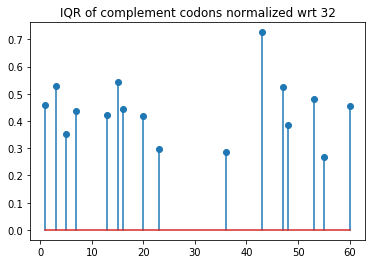

In [50]:
plt.stem(complements, [np.percentile(normalize_wrt_32(i),75) - np.percentile(normalize_wrt_32(i),25) for i in complements])
plt.title("IQR of complement codons normalized wrt 32")

Earlier, we called the deconvolve procedure that did the ridge regression and returned to us a Python list of 850 Python dictionaries, with each dictionary storing unnormalized codon elongation rates for every codon appearing in that gene index. 

To execute the normalization process, suppose we set the site-specific jump rate (ssjr) of codon 32 equal to 1 in every gene. However there are 5 genes in which codon 32 does not show up; for those genes we will use codon 55 as a reference point instead (since 55 appears in each of those 5 extra genes, and has lowest variance in normalized estimate). So therefore our first task will be normalizing the elongation rates of codon 32 and codon 55 with respect to each other, by finding all the genes in which both codons show up.

[0.10044176545481996, 1.0763315374070486, 0.328131706272294, 2.591223202223902, 0.06581386820863767, 0.23566720968862284, 0.0630606531069949, 0.4415230757293586, 0.32095234684899426, 0.22881760811355786, 0.22268015414580156, 0.1574967076073066, 0.1879243181682893, 0.16781897407791593, 0.14113095925209132, 0.12216649724410882, 1.4416622987043095, 0.3382178203035891, 0.10946095262957065, 0.451446385150926, 0.13349990488738542, 0.06734541120411143, 0.31706228738185166, 0.43307709820717977, 0.038787415604325214, 1.107002518109307, 0.5923881268720087, 0.18654990910782768, 0.12420360861319218, 0.322763627777381, 0.37788322645795647, 0.4596423740919777, 0.4177465548584533, 1.3534062761421541, 0.9469564404181215, 0.6825483525449233, 0.6012790730772358, 0.06884699292008128, 0.03189491917794433, 0.05087654721557829, 0.05012503308382017, 0.11826257865777422, 0.39024132478748585, 0.01861215474419582, 0.0439683407321401, 0.3094327316917864, 0.4151520815273313, 1.1629206964281342, 1.961248256900962,

(array([662.,  12.,   3.,   1.,   0.,   1.,   1.,   0.,   0.,   1.]),
 array([5.70381758e-03, 1.50040789e+00, 2.99511196e+00, 4.48981603e+00,
        5.98452010e+00, 7.47922418e+00, 8.97392825e+00, 1.04686323e+01,
        1.19633364e+01, 1.34580405e+01, 1.49527445e+01]),
 <a list of 10 Patch objects>)

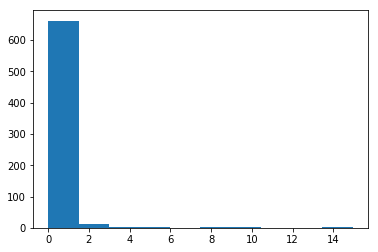

In [51]:
# Find genes where both codon 55 and codon 32 show up. Create list of values for normalized elongation rate of codon 55.
codon_55_normalized_rates = []

for g in range(num_genes):
    trunc_codon_seq = truncated_codon_sequences[g]
    trunc_gene_length = len(trunc_codon_seq)
    if 55 in trunc_codon_seq and 32 in trunc_codon_seq:
        old_ssjr_32 = site_specific_jump_rates[g][32]
        old_ssjr_55 = site_specific_jump_rates[g][55]
        normalized_codon_55_ssjr = (old_ssjr_55) / (old_ssjr_32)
        codon_55_normalized_rates.append(normalized_codon_55_ssjr)
        
print(codon_55_normalized_rates)
print("median normalized elongation rate: " + str(np.median(codon_55_normalized_rates)))
print("stdev normalized elongation rate: " + str(np.std(codon_55_normalized_rates)))
print("IQR normalized elongation rate: " + str(np.percentile(codon_55_normalized_rates,75) - \
                                               np.percentile(codon_55_normalized_rates,25)))
plt.hist(codon_55_normalized_rates) #, bins = [i*0.25 for i in range(0,9)])

In [84]:
# More info on the two outlier indices that we cut out from above (indices 320, 565)
print(site_specific_jump_rates[320])
print()
print(site_specific_jump_rates[565])

{0: 286.0970643683214, 1: 131.34768642775884, 2: 241.24696703970227, 3: 740.9492820596065, 7: 412.8679265698689, 9: 477.0704848421079, 11: 1033.8137364508839, 12: 402.1370708379112, 14: 127.42168868970106, 15: 588.0872062357639, 16: 953.8928189109142, 18: 1095.9520102720705, 20: 1038.8539541326234, 22: 312.10628778572783, 23: 1551.927915695843, 32: 103.93045384493303, 35: 232.86518344464142, 36: 428.3898643639844, 37: 327.2485446846601, 38: 167.11535308727315, 39: 1781.2574790065646, 40: 343.1413986047343, 41: 408.07508361844543, 42: 151.44362014788328, 43: 1052.862064464697, 45: 163.64966919201592, 46: 108.2952684596856, 48: 477.9005713330304, 49: 829.0198231449349, 50: 124.35660696196767, 53: 349.62048511371194, 57: 253.56378443980407, 58: 662.1298879062554, 59: 320.3855226248669, 60: 694.3645621087363}

{0: 802.7067611034795, 1: 698.8655735549577, 2: 930.5613624492777, 4: 916.1855357663693, 5: 644.9651324634822, 6: 683.6913578358042, 7: 553.9818025907347, 8: 282.14642596347693, 9: 1

The below cell searches for the codon that, amongst all 60 options, when its elongation rate is normalized with respect to codon 32, has the lowest variance in estimated values.

Text(0.5, 1.0, 'IQR of normalized elongation rates for each codon')

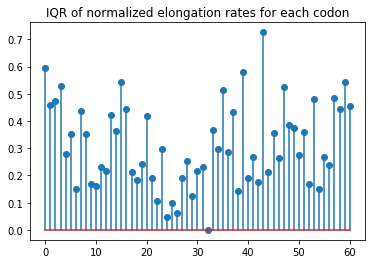

In [46]:
def normalize_wrt_32(codon_num):
    """Returns normalized elongation rates of a certain codon with respect to codon 32."""
    normalized_elongation_rates = []
    for g in range(num_genes):
        trunc_codon_seq = truncated_codon_sequences[g]
        trunc_gene_length = len(trunc_codon_seq)
        if codon_num in trunc_codon_seq and 32 in trunc_codon_seq:
            old_ssjr_32 = site_specific_jump_rates[g][32]
            old_ssjr_cn = site_specific_jump_rates[g][codon_num]
            normalized_rate = (old_ssjr_cn) / (old_ssjr_32)
            normalized_elongation_rates.append(normalized_rate)
    return normalized_elongation_rates

plt.stem([np.percentile(normalize_wrt_32(i),75) - np.percentile(normalize_wrt_32(i),25) for i in range(61)])
plt.title("IQR of normalized elongation rates for each codon")

Let's try Approach B now: normalizing all the elongation rates with respect to those of codon 32 and 55. We are going to establish that the elongation rate of codon 55 is 0.1913.

In [53]:
def normalize_wrt_55(codon_num):
    """Returns list of normalized elongation rates of a certain codon with respect to codon 55."""
    normalized_elongation_rates = []
    for g in range(num_genes):
        trunc_codon_seq = truncated_codon_sequences[g]
        trunc_gene_length = len(trunc_codon_seq)
        if codon_num in trunc_codon_seq and 55 in trunc_codon_seq:
            old_ssjr_55 = site_specific_jump_rates[g][55]
            old_ssjr_cn = site_specific_jump_rates[g][codon_num]
            normalized_rate = (old_ssjr_cn * 0.1913) / (old_ssjr_55)
            normalized_elongation_rates.append(normalized_rate)
    return normalized_elongation_rates

In [57]:
normalized_elongation_rates = np.zeros(61)
normalized_elongation_rates[32] = 1
normalized_elongation_rates[55] = 0.1913
elongation_rate_iqrs = np.zeros(61)
elongation_rate_iqrs[55] = 0.2695

codons_to_process = list(range(61))
codons_to_process.remove(32)
codons_to_process.remove(55)
for c in codons_to_process:
    iqr_32, iqr_55 = np.infty, np.infty
    if 32 in codon_seq:   
        wrt_32 = normalize_wrt_32(c)
        iqr_32 = np.percentile(wrt_32,75) - np.percentile(wrt_32,25)
    if 55 in codon_seq:   
        wrt_55 = normalize_wrt_55(c)
        iqr_55 = np.percentile(wrt_55,75) - np.percentile(wrt_55,25)
    if iqr_32 <= iqr_55:   # choose which estimate gives lower IQR
        normalized_elongation_rates[c] = np.median(wrt_32)
        elongation_rate_iqrs[c] = iqr_32
    else:
        normalized_elongation_rates[c] = np.median(wrt_55)
        elongation_rate_iqrs[c] = iqr_55

In [56]:
normalized_elongation_rates

array([0.72209883, 0.49501622, 0.6386377 , 0.50982287, 0.24490866,
       0.31978088, 0.1076102 , 0.45572587, 0.40818885, 0.11175787,
       0.11307286, 0.19750113, 0.17028045, 0.40797967, 0.35364651,
       0.6729812 , 0.53120444, 0.16287202, 0.15160325, 0.2249801 ,
       0.44794949, 0.15083238, 0.07787774, 0.29003009, 0.03965424,
       0.06739832, 0.04551159, 0.17494176, 0.23157052, 0.09124928,
       0.16219594, 0.18362137, 1.        , 0.39098626, 0.30173829,
       0.65174532, 0.27142784, 0.38203021, 0.11600096, 0.58589819,
       0.15018392, 0.18776483, 0.10430474, 0.69421403, 0.19123862,
       0.33819805, 0.19704872, 0.57184344, 0.33101736, 0.31923758,
       0.24184733, 0.32601223, 0.12169727, 0.5174871 , 0.09041806,
       0.1913    , 0.19964149, 0.49119002, 0.43583394, 0.66995675,
       0.42721359])

Text(0.5, 1.0, 'IQRs of normalized elongation rates')

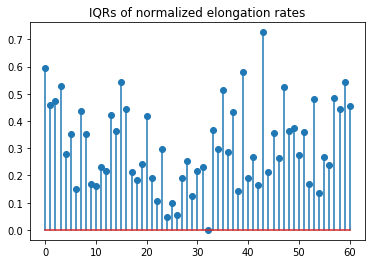

In [59]:
plt.stem(elongation_rate_iqrs)
plt.title('IQRs of normalized elongation rates')

To Do List:
1. Let's just do the NNLS instead of ridge regression muahahah.
2. Be sure to set tau such that tau is a constant and does not scale either.
3. See if there is a correlation between the small values and frequency of occurrence.
4. Create the graph of the ridge regression estimate with standard deviation shadow with tau values 0,0.1,1,100,1000 to kind of argue that NNLS is good enough in comparison to the ridge regression.
5. Normalization task: greedy algorithm not only takes in initial codon, but after every codon taken in it readjusts the estimates for each codon's elongation rate and selects to proceed with whichever codon has the smallest variance. So make sure to implement the real-time update for variance.